# In this file we calibrate of the Heston model through the pointwise approach
In the forward pass we learn the **mapping** between **Heston parameters** and the option prices.  
Below we generate the inputs consisting of combination of Heston parameters and of contract (EU vanilla calls) parameters.

In [1]:
import numpy as np
import tensorflow as tf
import itertools

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def generate_training_samples():
    """
    Generate training samples for Heston model calibration
    
    Returns:
    - contract_params: Tensor of contract parameters (strike, time to maturity)
    - heston_params: Tensor of Heston model parameters
    """
    
    # Contract Parameters Generation
    # Strike (K) from 0.6 to 1.4 with step 0.1
    strikes = np.arange(0.6, 1.5, 0.1)
    
    # Time to Maturity (tau) 10 values from 0.1 to 3.0 equispaced
    time_to_maturities = np.linspace(0.1, 3.0, 10)
    
    # Create all combinations of strikes and maturities
    contract_combinations = list(itertools.product(strikes, time_to_maturities))
    contract_params = tf.convert_to_tensor(contract_combinations, dtype=tf.float32)
    
    # Heston Parameters Generation
    # Generate 5000 Heston parameter combinations
    # Uniform Distributions based on specified ranges
    rho = np.random.uniform(-0.9, -0.1, 5000)        # Correlation
    k = np.random.uniform(0.1, 3.0, 5000)            # Mean reverting speed
    gamma = np.random.uniform(0.01, 0.8, 5000)       # Volatility of variance
    nu0 = np.random.uniform(0.05, 0.5, 5000)         # Starting variance
    theta = np.random.uniform(0.01, 0.5, 5000)       # Mean reverting level
    
    # Combine Heston parameters into a single tensor
    heston_params = tf.convert_to_tensor(np.column_stack([rho, k, gamma, theta, nu0]), 
                                         dtype=tf.float32)
    
    return contract_params, heston_params

# Create the combinations
contract_params, heston_params = generate_training_samples()

# Info about the generated samples
print("Contract Parameters:")
print(f"Number of samples: {contract_params.shape[0]}")
print(f"Strikes range: [{np.min(contract_params[:, 0]):.2f}, {np.max(contract_params[:, 0]):.2f}]")
print(f"Time to Maturities range: [{np.min(contract_params[:, 1]):.2f}, {np.max(contract_params[:, 1]):.2f}]")

print("\nHeston Parameters:")
print(f"Number of samples: {heston_params.shape[0]}")
heston_param_names = ['ρ (Correlation)', 'k (Mean Reverting Speed)', 
                      'γ (Volatility of Variance)', 'θ (Mean Reverting Level)', 
                      'ν0 (Starting Variance)']

for i, name in enumerate(heston_param_names):
    print(f"{name} range: [{np.min(heston_params[:, i]):.4f}, {np.max(heston_params[:, i]):.4f}]")

Contract Parameters:
Number of samples: 90
Strikes range: [0.60, 1.40]
Time to Maturities range: [0.10, 3.00]

Heston Parameters:
Number of samples: 5000
ρ (Correlation) range: [-0.9000, -0.1002]
k (Mean Reverting Speed) range: [0.1002, 2.9986]
γ (Volatility of Variance) range: [0.0101, 0.7998]
θ (Mean Reverting Level) range: [0.0100, 0.5000]
ν0 (Starting Variance) range: [0.0501, 0.5000]


Now we have to compute the EU vanilla call prices through FFT to have the ground truth of the forward pass, here's the **FFT algorithm** to compute them

In [2]:
from scipy.interpolate import interp1d

def char_exp(v, params,T):
    """
    Characteristic exponent for Heston 1993 model (B(ψ) + C(ψ))
    
    Parameters:
    - v: Fourier transform variable (can be array or scalar)
    - params: tensor containing Heston parameters:
    -T: time to maturity
    
    Returns:
    - Characteristic exponent value(s)
    """
    # Extract parameters (rho, k, gamma, theta, nu0)
    rho = params[0]
    kappa = params[1]
    sigma = params[2]
    theta = params[3]
    V0 = params[4]
     
    # Calculate intermediate terms
    zeta = -0.5 * (v**2 + 1j*v)  # ζ(ω)
    gamma = kappa - rho * sigma * v * 1j  # γ(ω)
    psi = np.sqrt(gamma**2 - 2 * sigma**2 * zeta)  # ψ(ω)
    
    # Calculate B(ψ)
    numerator_B = 2 * zeta * (1 - np.exp(-psi * T)) * V0
    denominator_B = 2 * psi - (psi - gamma) * (1 - np.exp(-psi * T))
    B = numerator_B / denominator_B
    
    # Calculate C(ψ)
    log_term = np.log((2 * psi - (psi - gamma) * (1 - np.exp(-psi * T))) / (2 * psi))
    C = (-2 * kappa * theta / sigma**2) * (2 * log_term + (psi - gamma) * T)
    
    return B + C

def cf_Heston(v, T, r, params):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    
    Parameters:
    - v: Fourier transform variable (can be array or scalar)
    - T: time to maturity
    - r: risk-free interest rate
    - params: tensor containing Heston parameters:

    
    Returns:
    - Characteristic function value(s)
    """
    # Extract parameters (rho, k, gamma, theta, nu0)
    rho = params[0]
    kappa = params[1]
    sigma = params[2]
    theta = params[3]
    v0 = params[4]

    xi = kappa - sigma * rho * v * 1j
    d = np.sqrt(xi**2 + sigma**2 * (v**2 + 1j * v))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * v * r * T
        + (kappa * theta) / (sigma**2) * ((xi - d) * T - 2 * np.log((1 - g2 * np.exp(-d * T)) / (1 - g2)))
        + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * T)) / (1 - g2 * np.exp(-d * T))
    )
    return cf


def FFT_CM_Call(Strike, params, T, r, S0):
    """
    Compute EU vanilla option prices using Carr-Madan FFT method
    
    Parameters:
    - Strike: Strike prices
    - params: Model parameters
    - T: Time to maturity
    - r: Risk-free rate
    - S0: Spot price
    
    Returns:
    - Option prices for that given maturity
    """
    # Discretization parameters
    Npow = 15
    N = 2**Npow
    A = 1200

    # Discretization step
    eta = A/N
    
    # Avoid division by zero
    v = np.arange(0, A*(N-1)/N + eta, eta)
    v[0] = 1e-22

    # Numerical parameter for log-moneyness grid
    lambda_param = 2 * np.pi / (N * eta)
    
    # Grid of log-moneyness
    k = -lambda_param * N/2 + lambda_param * np.arange(N)

    # Characteristic function
    #char_func = lambda v: np.exp(char_exp(v, params,T))
    char_func = lambda v: cf_Heston(v, T, r, params)

    # Carr-Madan argument of inverse Fourier transform
    Z_k = np.exp(1j * r * v * T) * \
          (char_func(v - 1j) - 1) / (1j * v * (1j * v + 1))

    # Trapezoidal integration weights
    w = np.ones(N)
    w[0] = 0.5
    w[-1] = 0.5

    # Compute option prices via FFT
    x = w * eta * Z_k * np.exp(1j * np.pi * np.arange(N))
    z_k = np.real(np.fft.fft(x) / np.pi)

    # Compute strikes and call prices
    K = S0 * np.exp(k)
    C = S0 * (z_k + np.maximum(1 - np.exp(k - r * T), 0))

    # Filter reasonable strikes
    index = np.where((K > 0.1 * S0) & (K < 3 * S0))[0]
    K_filtered = K[index]
    C_filtered = C[index]

    # Interpolate to get prices for given strikes
    price_interp = interp1d(K_filtered, C_filtered, kind='cubic', 
                             fill_value='extrapolate')
    
    return price_interp(Strike)

We would like to make a comparison between the FFT algorithm and the Monte-Carlo simulation to show both the **accuracy** and **efficiency** and also to make a double check  
on the code. 

For the MC simulation, we rely on the Implementation of Euler Scheme for Heston model,but also ensuring that the variance process Vt is always non-negative.


Feller Condition satisfied

Martingale check: E[e^(-rT)S_T] = 0.998018 vs S0 = 1.0

Monte Carlo Execution Time: 1.3930 seconds
FFT Execution Time: 0.0469 seconds


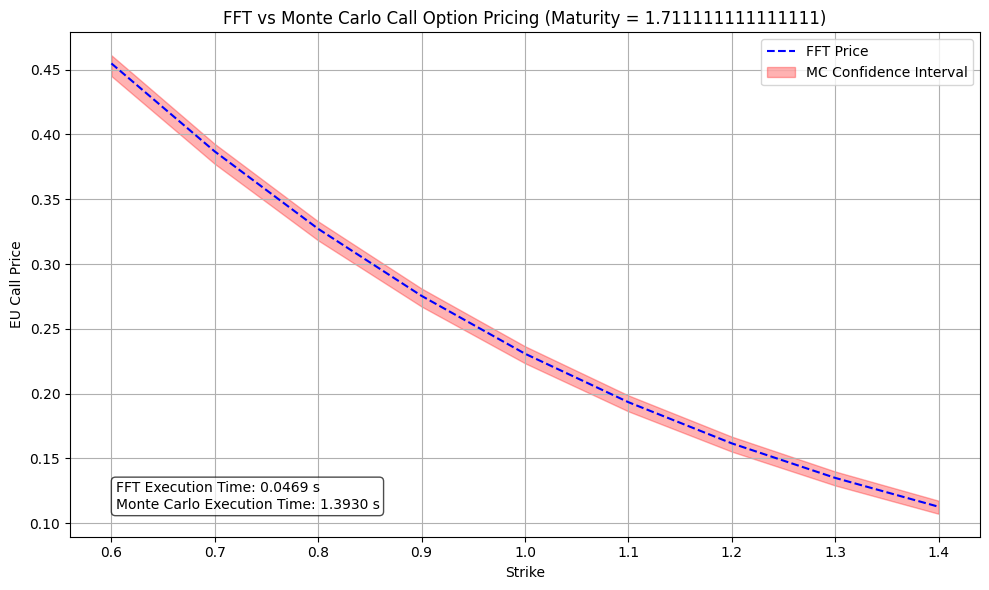

array([-0.36956224,  0.80991966,  0.40485957,  0.30519328,  0.14492872],
      dtype=float32)

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import norm
import time

#Fix seed
np.random.seed(5)
S0=1.0                                          #Spot price
r=0.0                                           #risk-free interest rate
strikes = np.arange(0.6, 1.5, 0.1)              #strikes
time_to_maturities = np.linspace(0.1, 3.0, 10)  #maturities
T = time_to_maturities[5]                       # pick intermediate maturity for comparison

random_index = np.random.randint(0, len(heston_params))
heston_sample = heston_params[random_index].numpy() #pick a random set of Heston parameters


def Heston_paths(params, N=252, paths=20000, T=T, S0=S0, r=r):
    """
    Simulate paths from Heston model through Euler scheme, ensuring the variance is always positive through absolute value.
    
    Parameters:
    - N: time steps
    - paths: number of simulations
    - T: maturity
    - r: risk-free interest rate
    - params: Heston parameters
    
    Output:
    - S: simulated asset paths
    """
    rho, kappa, sigma, theta, v0 = params

    # Verify Feller condition
    feller_condition = sigma**2 - 2*kappa*theta
    if feller_condition <= 0:
        print('Feller Condition satisfied')
    else:
        print('Feller Condition NOT satisfied')
    
    # temporal discretization
    dt = T/N
    
    # initialize process
    x = np.zeros((paths, N+1))
    x[:, 0] = np.log(S0)
    
    V = np.zeros((paths, N+1))
    V[:, 0] = v0
    
    # covariance matrix for gaussian sampling
    mu_vec = np.array([0, 0])
    VC = np.array([[1, rho], [rho, 1]])
    
    # Monte Carlo simulation
    for i in range(N):
        # sample correlated gaussians
        Z = np.random.multivariate_normal(mu_vec, VC, paths)
        
        # update log-price process
        x[:, i+1] = (x[:, i] + 
                     (r- V[:, i]/2) * dt + 
                     np.sqrt(V[:, i] * dt) * Z[:, 0])
        
        # update variance process through absolute value
        V[:, i+1] = np.abs(V[:, i] + 
                           kappa * (theta - V[:, i]) * dt + 
                           sigma * np.sqrt(V[:, i] * dt) * Z[:, 1])
    
    # 
    S = np.exp(x)

    #martingale check
    martingale_check = np.mean(np.exp(-r*T) * S[:,-1])  # E[e^{-r*T+X_T}]
    print(f"\nMartingale check: E[e^(-rT)S_T] = {martingale_check:.6f} vs S0 = {S0}")
    
    return S, V

# Heston paths simulation (timed)

start_mc = time.time()
S, _ = Heston_paths(heston_sample, N=252, paths=20000, T=T, S0=S0, r=r)
end_mc = time.time()

mc_time = end_mc - start_mc    #measure the time

def monte_carlo_call_price(r, T, K, ST):
    """
    Compute the Monte Carlo price of a EU vanilla call.
    
    Parameters:
    S0 (float): asset price at t=0
    r (float): risk-free rate
    T (float): Time to maturity
    K (float): Strike price
    ST (np.ndarray): Simulated asset prices at time T
    
    Output:
    priceMC (float): mean price
    priceMC_CI (tuple): confidence interval (lower, upper)
    """
    disc_payoff = np.exp(-r * T) * np.maximum(ST - K, 0)
    
    priceMC = np.mean(disc_payoff)
    #std_err = np.std(disc_payoff) / np.sqrt(len(disc_payoff))
    std_err = ss.sem(disc_payoff)
    ci = norm.ppf(0.975) * std_err
    priceMC_CI = (priceMC - ci, priceMC + ci)
    
    return priceMC, priceMC_CI

#Compute Monte Carlo prices and confidence intervals
mc_prices_ci = [monte_carlo_call_price(r, T, K, S[:,-1]) for K in strikes]

# Measure FFT time
start_fft = time.time()
fft_prices = np.array(FFT_CM_Call(strikes, heston_sample, T, r, S0)).flatten()
end_fft = time.time()
fft_time = end_fft - start_fft

def plot_fft_vs_mc(strikes, fft_prices, mc_prices_ci, T):
    """
    Compare MC and FFT prices with execution times.
    
    Parameters:
    strikes (list): strikes list
    fft_prices (list): FFT prices
    mc_prices_ci (list of tuples): MC confidence intervals
    T (float): Time to maturity
    """
    
    mc_down = [ci[1][0] for ci in mc_prices_ci]
    mc_up = [ci[1][1] for ci in mc_prices_ci]
    
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, fft_prices, label='FFT Price', color='blue', linestyle='--')
    plt.fill_between(strikes, mc_down, mc_up, color='red', alpha=0.3, label='MC Confidence Interval')
    plt.xlabel('Strike')
    plt.ylabel('EU Call Price')
    plt.title(f'FFT vs Monte Carlo Call Option Pricing (Maturity = {T})')
    plt.legend()
    plt.grid(True)
    
    # Annotate execution times
    plt.text(0.05, 0.05, f'FFT Execution Time: {fft_time:.4f} s\nMonte Carlo Execution Time: {mc_time:.4f} s', 
             transform=plt.gca().transAxes, 
             verticalalignment='bottom', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Print results
print(f"\nMonte Carlo Execution Time: {mc_time:.4f} seconds")
print(f"FFT Execution Time: {fft_time:.4f} seconds")

# Visualize plot
plot_fft_vs_mc(strikes, fft_prices, mc_prices_ci, T)
heston_sample

In [4]:
#Now after defining the FFT we can cycle over all the Heston parameters combinations and all the contracts maturities
#in order to get all the option prices

def calculate_option_prices(heston_params, contract_params, r=0.0, S0=1.0):
    """
    Calculate option prices efficiently using FFT for all strikes at same maturity
    
    Parameters:
    - heston_params: Tensor of Heston parameters, here (5000, 5)
    - contract_params: Tensor of contract parameters (strikes, maturities) pairs (90, 2)
    - r: Risk-free rate, here is 0
    - S0: Spot price, here is 1
    
    Returns:
    - Tensor of option prices, here (5000, 90)
    """
    # Convert to numpy for easier iteration
    heston_params_np = heston_params.numpy()
    contract_params_np = contract_params.numpy()
    
    # Preallocate array for option prices
    option_prices = np.zeros((heston_params_np.shape[0], contract_params_np.shape[0]))
    
    # Find unique maturities
    unique_maturities = np.unique(contract_params_np[:, 1])
    
    # Iterate through Heston parameters
    for i, params in enumerate(heston_params_np):
        # Calculate prices for all unique maturities
        for maturity in unique_maturities:
            # Find indices of contract parameters with this maturity
            maturity_indices = np.where(contract_params_np[:, 1] == maturity)[0]
            
            # Extract strikes for this maturity
            strikes_for_maturity = contract_params_np[maturity_indices, 0]
            
            # Calculate option prices for all strikes at this maturity using FFT
            prices_for_maturity = np.maximum(FFT_CM_Call(strikes_for_maturity, params, maturity, r, S0), 1e-10)  
            
            # Store prices in the correct positions
            option_prices[i, maturity_indices] = prices_for_maturity
        
        # Progress tracking
        if (i + 1) % 500 == 0:
            print(f"Processed {i+1}/{heston_params_np.shape[0]} parameter sets")
    
    # Convert back to TensorFlow tensor
    return tf.convert_to_tensor(option_prices, dtype=tf.float32)

# Compute option prices
option_prices = calculate_option_prices(heston_params, contract_params)

# Print info
print("Option Prices Shape:", option_prices.shape)
print("Mean Option Price:", tf.reduce_mean(option_prices).numpy())
print("Min Option Price:", tf.reduce_min(option_prices).numpy())
print("Max Option Price:", tf.reduce_max(option_prices).numpy())

Processed 500/5000 parameter sets
Processed 1000/5000 parameter sets
Processed 1500/5000 parameter sets
Processed 2000/5000 parameter sets
Processed 2500/5000 parameter sets
Processed 3000/5000 parameter sets
Processed 3500/5000 parameter sets
Processed 4000/5000 parameter sets
Processed 4500/5000 parameter sets
Processed 5000/5000 parameter sets
Option Prices Shape: (5000, 90)
Mean Option Price: 0.24885303
Min Option Price: 1e-10
Max Option Price: 0.5919306


# CaNN: Calibration Neural Network
Step 1: *Forward Pass*
Now that we have both the input and output prepared, we can set up our neural network composed of:

- **3 hidden layers**, each with **50 neurons**  
- **Activation functions**, Mix of activation functions to capture complex non-linearities: **Swish**, **Tanh**, **Leaky_ReLU** and **softplus** in the output layer, smoother than ReLU for prices close to 0
- **No dropout layers**  
- **No Batch normalization**  I don't want to scale the data, I want the explicit mapping without any scaling for better later interpretability analysis 
- **Batch size**: **1024**  
- **Optimizer**: **Adam**  
- **Learning rate scheduler**: halves the learning rate (initially set to **1e-3**) down to **1e-6** if the validation loss does not improve 
- **Loss**: MSE, MAPE metric to keep track of percentage error 

We can now train the network to learn the **mapping**.

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.backend as K

#  1: Forward Pass - learn mapping from Heston parameters + contract parameters -> option price
def create_forward_model():
    """
    Create forward pass with the following architecture:

    - 3 hidden layers (50 neurons each)
    - Activation functions: swish, tanh, leaky ReLU
    - Output layer: 1 neuron with relu activation
    """
    input_layer = Input(shape=(9,), name='forward_input')  # 5 Heston parametrs + 4 contract parametrs
    #x = BatchNormalization()(input_layer)  # Normalize input improving training stability

    # Hidden layers
    hidden1 = Dense(50, activation='swish', name='hidden1')(input_layer)
    hidden2 = Dense(50, activation='tanh', name='hidden2')(hidden1)
    hidden3 = Dense(50, activation='leaky_relu', name='hidden3')(hidden2)
    
    # Output layer
    output_layer = Dense(1, activation='softplus', name='price_output')(hidden3)
    
    # Model construction
    model = Model(inputs=input_layer, outputs=output_layer, name='ForwardModel')
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    
    return model

def train_forward_model(X, y, validation_split=0.2):
    """
    Train the model with following specifications:
    - Batch size: 1024
    - Max epoch: 300
    - LR scheduler and early stopping
    
    Returns:
    - model: trained model
    - history: training history
    """
    # Create the model
    model = create_forward_model()
    
    # Callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=5e-5,
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X, y,
        batch_size=1024,
        epochs=300,
        validation_split=validation_split,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )
    
    # Print model summary with # of trainable layers and parameters
    model.summary(expand_nested=True, show_trainable=True)
    
    return model, history

# Second part
Step 2: *Backward Pass*
Now that we have trained the forward pass and learnt the map from the parameters to option prices we can calibrate online:

- **Inputs**: the trained forward pass, market data: options parameters and prices, regularization coefficient for the Heston parameters norm
- **Freeze the forward pass MLP**, exclude the input layer to make it trainable, set an initial guess for Heston parameters
- **Compute model prices** with the current set of parameters (for all options) leveraging the frezone map
- **Compute total loss**: weighted MSE, heavier weights for ATM strikes, regularization loss 
- **Training step**: compute the gradients of the total loss with respect to Heston parameters, apply those gradients to update the Heston parameters using Adam optimizer
- **Early stopping** applied

We can now efficently and **quickly** calibrate the Heston parameters.

In [6]:
# Part 2: Backward Pass - calibration (find Heston parametrs from observed market prices)
class HestonCalibrationModel(tf.keras.Model):
    def __init__(self, forward_model, contract_params, market_prices, lambda_reg=1e-4):
        """
        Initialize model for the calibration from the trained forward model 
        
        Parameters:
        - forward_model: trained forward model 
        - contract_params: contract parameters (shape: (n_contracts, 4))
        - market_prices: observed market prices (shape: (n_contracts,))
        - lambda_reg: regularization coefficient for Heston parameters magnitude
        """
        super(HestonCalibrationModel, self).__init__()
        
        # Save forward model without input layer
        self.hidden_layers = forward_model.layers[1:]  # Exclude input layer
        
        # Freeze hidden layers weights
        for layer in self.hidden_layers:
            layer.trainable = False
        
        # Create a trainable layer for Heston parameters 
        self.heston_params = tf.Variable(
            initial_value = tf.concat([
                tf.random.uniform(shape=(1, 1), minval=-0.9, maxval=-0.1),  # ρ initial guess
                tf.random.uniform(shape=(1, 1), minval=0.1, maxval=3.0),    # k initial guess
                tf.random.uniform(shape=(1, 1), minval=0.01, maxval=0.8),   # γ initial guess
                tf.random.uniform(shape=(1, 1), minval=0.01, maxval=0.5),   # θ initial guess
                tf.random.uniform(shape=(1, 1), minval=0.05, maxval=0.5)    # ν0 initial guess
            ], axis=1),
            dtype=tf.float32,
            trainable=True,
            name='learnable_heston_params'
        )
        
        # Save contract parameters and merket prices
        self.contract_params = tf.convert_to_tensor(contract_params, dtype=tf.float32)
        self.market_prices = tf.convert_to_tensor(market_prices, dtype=tf.float32)
        self.lambda_reg = lambda_reg
        
        # Number of contracts
        self.n_contracts = self.contract_params.shape[0]
    
    def call(self, inputs, training=False):
        """
        Forward pass of model calibration needed for the loss of backward pass
        
        Returns:
        - model_prices: model prices
        """
        # Replicate Heston parameters for each contract
        heston_params_repeated = tf.repeat(self.heston_params, self.n_contracts, axis=0)
        
        # Concatenate Heston ripetuted parameters with contract parameters 
        model_input = tf.concat([heston_params_repeated, self.contract_params], axis=1)
        
        # Apply the forward pass learned map
        x = model_input
        for layer in self.hidden_layers:
            x = layer(x)
        
        # Restiturn model prices
        model_prices = x
        return model_prices
    
    def compute_loss(self):
        """
        Compute the calibration loss:
        - Weighted loss between market and model prices
        - Regularization term on the Heston parameters vector norm
        """
        # Get model prices
        model_prices = self.call(None)
        
        # Compute weights based on (S0-K) difference (we want to better fit ATM options)
        strikes = self.contract_params[:, 0] 
        S0 = 1.0
        weights = 1.0 / tf.maximum(tf.abs(S0 - strikes), 1e-1)
        
        # Compute weighted loss
        price_diff = model_prices[:, 0] - self.market_prices
        weighted_mse = tf.reduce_mean(weights * tf.square(price_diff))
        
        # Regularization term (euclidean norm of parameters)
        reg_term = self.lambda_reg * tf.reduce_sum(tf.square(self.heston_params))
        
        # Total loss
        total_loss = weighted_mse + reg_term
        
        return total_loss, weighted_mse, reg_term
    
    def train_step(self, unused_data):
        """
        Perform an optimization step
        """
        with tf.GradientTape() as tape:
            total_loss, weighted_mse, reg_term = self.compute_loss()
        
        # Compute gradient with respect to heston parameters
        gradients = tape.gradient(total_loss, [self.heston_params])
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, [self.heston_params]))
        
        return {"loss": total_loss, "weighted_mse": weighted_mse, "reg_term": reg_term}
    
    def get_calibrated_params(self):
        """
        Return calibrated Heston parameters 
        """
        return self.heston_params.numpy()

def calibrate_heston_model(forward_model, contract_params, market_prices, 
                          initial_params=None, lambda_reg=1e-4, learning_rate=1e-3, 
                          epochs=500, patience=50):
    """
    Calibrate Heston model using pre-trained forward pass
    
    Parameters:
    - forward_model: trained forward pass
    - contract_params: contract parameters (shape: (n_contracts, 4))
    - market_prices: observed market prices (shape: (n_contracts,))
    - initial_params: Heston parameters initial guess (if None, they're randomly sampled)
    - lambda_reg: regularization coefficient
    - learning_rate: learning rate for optimizer
    - epochs: max number of epochs
    - patience: early stopping parameter
    
    Returns:
    - calibrated_params: Heston calibrated parameters
    - history: calibration history
    """
    # Create calibration model
    calibration_model = HestonCalibrationModel(
        forward_model, 
        contract_params, 
        market_prices,
        lambda_reg
    )
    
    # Set initial guess
    if initial_params is not None:
        calibration_model.heston_params.assign(tf.convert_to_tensor(initial_params, dtype=tf.float32))
    
    # Compile the model
    calibration_model.compile(optimizer=Adam(learning_rate=learning_rate))
    
    # List to save history
    loss_history = []
    best_loss = float('inf')
    best_params = None
    patience_counter = 0
    
    # Training loop
    for epoch in range(epochs):
        metrics = calibration_model.train_step(None)
        loss = metrics["loss"].numpy()
        weighted_mse = metrics["weighted_mse"].numpy()
        reg_term = metrics["reg_term"].numpy()
        
        # Save history
        loss_history.append({
            "epoch": epoch + 1,
            "loss": loss,
            "weighted_mse": weighted_mse,
            "reg_term": reg_term,
            "heston_params": calibration_model.get_calibrated_params().copy()
        })
        
        # Print training progess
        if (epoch + 1) % 30 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}, MSE: {weighted_mse:.6f}, Reg: {reg_term:.6f}")
            print(f"Heston params: {calibration_model.get_calibrated_params()[0]}")
        
        # Verify early stopping criterion
        if loss < best_loss:
            best_loss = loss
            best_params = calibration_model.get_calibrated_params().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
    
    # Set best parameters found
    calibration_model.heston_params.assign(tf.convert_to_tensor(best_params, dtype=tf.float32))
    
    # Return calibrated parameters and history
    return best_params, loss_history

# Main function for ENTIRE Calibration 
Step 3: *Complete calibration*

Here we create a simple main for the entire calibration process, first **preparing the dataset** the input feature X, dimension (5000*90,5+4):
- 5000 is the # Heston parameters combinations, each one repeated 90 times (once for each contract), 5 are the Heston parameters and 4 the contract ones
- y (5000*90) vector of **contract prices**
- train+val-test **split**: 90-10
- train-val split: 80-20
- **plot** training history of Forward pass and the model architecture
- apply forward pass on the **test set** for a check
- **prepare the market data**, here a set of option prices picked from a random sampled set of Heston parameters
- **Calibrate**

=== Forward Pass: MLP training ===
Epoch 1/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0354 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - val_loss: 8.9216e-04 - learning_rate: 0.0010
Epoch 4/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7752e-04 - val_loss: 4.7544e-04 - learning_rate: 0.0010
Epoch 5/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.0789e-04 - val_loss: 2.8411e-04 - learning_rate: 0.0010
Epoch 6/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6569e-04 - val_loss: 2.2922e-04 - learning_rate: 0.0010
Epoch 7/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1331e-04 - val_loss: 1.8914e-04 - learning_rate: 0.0010
Epoch 8/300
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8062e-04 - val_loss: 1.6420e-04 - learning_rate: 0.0010
Epoch 9/300
317/317 ━━━━━━━━━━━━━

Model: "ForwardModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ forward_input (InputLayer)  │ (None, 9)             │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ hidden1 (Dense)             │ (None, 50)            │        500 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ hidden2 (Dense)             │ (None, 50)            │      2,550 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ hidden3 (Dense)             │ (None, 50)            │      2,550 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ price_output (Dense)        │ (None, 1)             │         51 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 16,955 (66.23 KB)

 Trainable params: 5,651 (22.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,304 (44.16 KB)

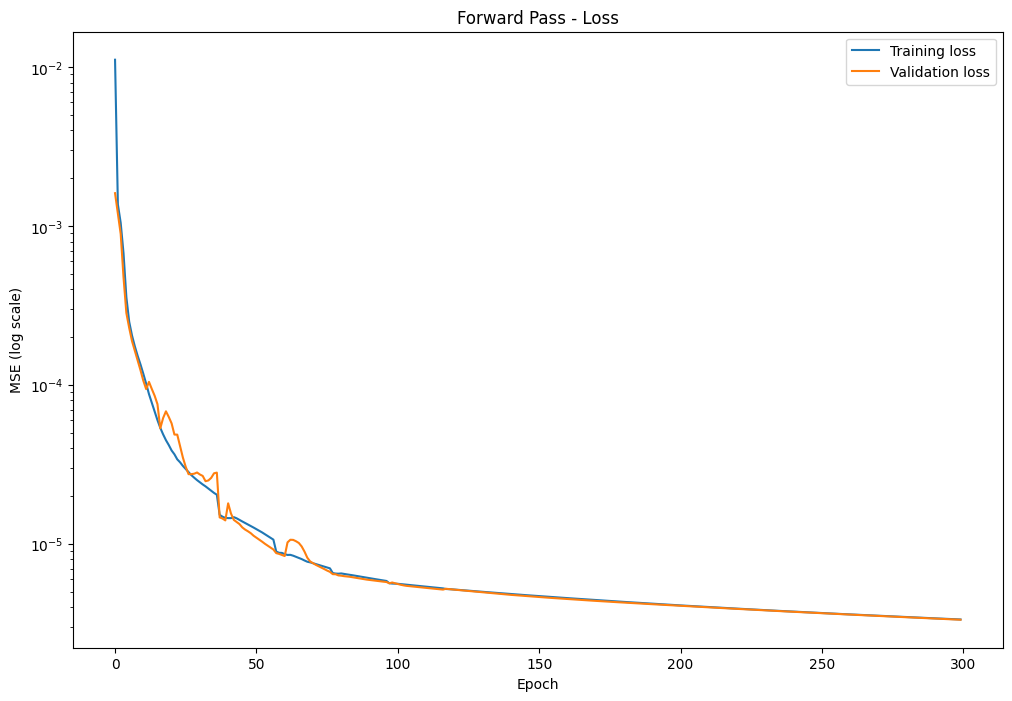

In [7]:
from sklearn.model_selection import train_test_split

# Main for entire process

# Step 1: Prepare data
def prepare_data(heston_params, contract_params, option_prices):
    """
    Prepare input data for neural network
    
    Parameters:
    - heston_params: Tensor of Heston parameters combinations, here (5000, 5)
    - contract_params: Tensor of contract parameters couples, here (90, 2)
    - option_prices: Tensor of option prices (5000, 90)
    
    Returns:
    - X: Input features (non-scaled)
    - y: Target option prices
    - expanded_contract_params: Contract parameters with S0 and r added
    """
    # Convert TensorFlow tensors to NumPy arrays if needed
    if isinstance(heston_params, tf.Tensor):
        heston_params = heston_params.numpy()
    if isinstance(contract_params, tf.Tensor):
        contract_params = contract_params.numpy()
    if isinstance(option_prices, tf.Tensor):
        option_prices = option_prices.numpy()
    
    # Create all combinations of Heston params, contract params, and prices
    X_heston = np.repeat(heston_params, contract_params.shape[0], axis=0)
    
    # Add S0=1 and r=0 to contract parameters
    S0 = np.ones((contract_params.shape[0], 1))
    r = np.zeros((contract_params.shape[0], 1))
    
    # Create expanded contract parameters with shape (90, 4)
    expanded_contract_params = np.hstack([contract_params, S0, r])
    
    # Tile expanded contract parameters
    X_contract = np.tile(expanded_contract_params, (heston_params.shape[0], 1))
    
    # Combine Heston and contract parameters
    X = np.hstack([X_heston, X_contract])
    
    # Flatten option prices
    y = option_prices.reshape(-1)
    
    # No standardization
    return X, y, expanded_contract_params

X, y, expanded_contract_params = prepare_data(heston_params, contract_params, option_prices)

# First divide data into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
# Step 2: Forward pass
print("=== Forward Pass: MLP training ===")
forward_model, forward_history = train_forward_model(X_train_val, y_train_val, validation_split=0.2)

#Visualize training hystory and MLP description
plt.figure(figsize=(12, 8))  
plt.plot(forward_history.history['loss'], label='Training loss')
plt.plot(forward_history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('Forward Pass - Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (log scale)')
plt.legend()

In [8]:
#Let's see how well we've learnt the mapping from parameters to prices on the test set
test_loss = forward_model.evaluate(X_test, y_test, verbose=1)
print(f"\n=== Test Loss: {test_loss:.6f} ===")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.2885e-06

=== Test Loss: 0.000003 ===



=== Backward Pass: Model Calibration ===
Epoch 30/500, Loss: 0.023772, MSE: 0.023747, Reg: 0.000025
Heston params: [-0.3980271   2.0646448   0.6254915   0.34306577  0.38168654]
Epoch 60/500, Loss: 0.016164, MSE: 0.016139, Reg: 0.000025
Heston params: [-0.4259133   2.0335948   0.65391916  0.31508866  0.35326147]
Epoch 90/500, Loss: 0.010267, MSE: 0.010243, Reg: 0.000024
Heston params: [-0.45138937  2.002619    0.6802691   0.28967127  0.32688817]
Epoch 120/500, Loss: 0.006198, MSE: 0.006174, Reg: 0.000024
Heston params: [-0.47350657  1.9731126   0.70328516  0.26782382  0.30341926]
Epoch 150/500, Loss: 0.003591, MSE: 0.003568, Reg: 0.000023
Heston params: [-0.49186778  1.9469794   0.72237515  0.2499415   0.28297052]
Epoch 180/500, Loss: 0.002139, MSE: 0.002116, Reg: 0.000023
Heston params: [-0.5062247   1.9263102   0.7370664   0.23645519  0.26580194]
Epoch 210/500, Loss: 0.001410, MSE: 0.001387, Reg: 0.000023
Heston params: [-0.51665235  1.9111863   0.74755555  0.22715428  0.25184014]
Ep

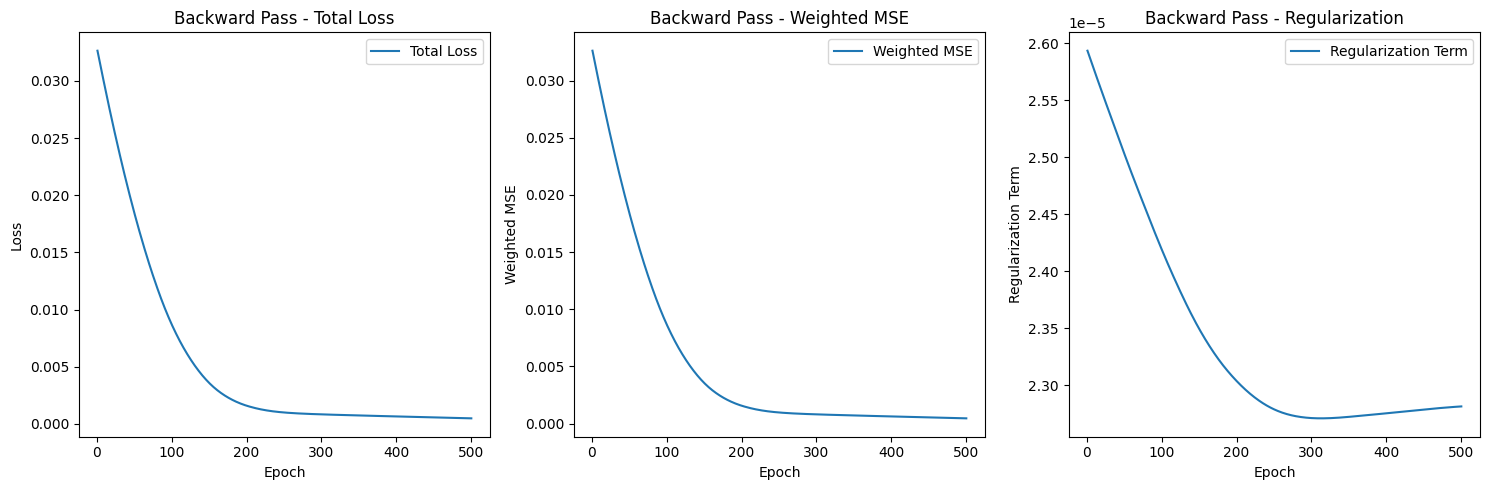


Calibration Execution Time: 11.1661 seconds

🔹 True Heston Parameters 🔹
 [[-0.8486329   2.5252447   0.7176811   0.26044112  0.05911222]]


In [9]:
# Step 3: Choose a set of contract parameters and market prices for the calibration
# We calibrate on the available contracts

# Take a simulation of the Heston parameters
random_idx = np.random.randint(0, heston_params.shape[0])
true_heston_params = heston_params[random_idx:random_idx+1]
market_prices = option_prices[random_idx]

# Measure Calibration time
start_calib = time.time()

# Step 4: Backward pass (calibration)
print("\n=== Backward Pass: Model Calibration ===")
calibrated_params, calibration_history = calibrate_heston_model(
    forward_model,
    expanded_contract_params,
    market_prices,
    lambda_reg=5e-6,
    learning_rate=1e-3,
    epochs=500,
    patience=50
)

end_calib = time.time()
calib_time = end_calib - start_calib

# Visualize the calibration history
epochs = [entry["epoch"] for entry in calibration_history]
losses = [entry["loss"] for entry in calibration_history]
mse_losses = [entry["weighted_mse"] for entry in calibration_history]
reg_losses = [entry["reg_term"] for entry in calibration_history]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, label='Total Loss')
plt.title('Backward Pass - Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, mse_losses, label='Weighted MSE')
plt.title('Backward Pass - Weighted MSE')
plt.xlabel('Epoch')
plt.ylabel('Weighted MSE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, reg_losses, label='Regularization Term')
plt.title('Backward Pass - Regularization')
plt.xlabel('Epoch')
plt.ylabel('Regularization Term')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nCalibration Execution Time: {calib_time:.4f} seconds\n")
print("🔹 True Heston Parameters 🔹\n", true_heston_params.numpy())

# Differential Evolution
In this section we use a parallel optimization gradient free method, the Differential evolution, which is suitable for the backward pass given the restricted number of weights and the high number of local minima of the non-convex loss function.

In [10]:
from scipy.optimize import differential_evolution

def calibrate_heston_with_DE(forward_model, contract_params, market_prices,mutation=0.65,recombination=0.8,
                            lambda_reg=1e-7, popsize=10, maxiter=40, tol=5e-4, seed=42):
    """
    Calibrate Heston model using Differential Evolution
    
    Parameters:
    - forward_model: trained forward pass model
    - contract_params: contract parameters (shape: (n_contracts, 4))
    - market_prices: observed market prices (shape: (n_contracts,))
    - lambda_reg: regularization coefficient
    - popsize: population size for DE (multiplier of the number of parameters)
    - maxiter: maximum number of generations
    - tol: convergence tolerance
    - seed: random seed for reproducibility
    
    Returns:
    - calibrated_params: calibrated Heston parameters
    - result: full optimization result object
    """
    # Define parameter bounds (rho, k, gamma, theta, nu0)
    bounds = [
        (-0.9, -0.1),    # rho (correlation)
        (0.1, 3.0),      # k (mean reversion speed)
        (0.01, 0.8),     # gamma (volatility of variance)
        (0.01, 0.5),     # theta (mean reversion level)
        (0.05, 0.5)      # nu0 (initial variance)
    ]
    
    # Convert contract parameters and market prices to TensorFlow tensors
    tf_contract_params = tf.convert_to_tensor(contract_params, dtype=tf.float32)
    n_contracts = tf_contract_params.shape[0]
    
    # Strikes for weighting (as in your original implementation)
    strikes = tf_contract_params[:, 0]
    S0 = 1.0
    weights = 1.0 / tf.maximum(tf.abs(S0 - strikes), 1e-1).numpy()
    
    # Define the objective function for optimization
    def objective_function(params):
        """Objective function for the differential evolution algorithm"""
        # Reshape parameters
        heston_params = np.array(params).reshape(1, -1)
        
        # Replicate Heston parameters for each contract
        heston_params_repeated = np.repeat(heston_params, n_contracts, axis=0)
        
        # Prepare input for the forward model
        model_input = np.hstack([heston_params_repeated, contract_params])
        
        # Get model prices using the forward model
        model_prices = forward_model.predict(model_input, verbose=0).ravel()
        
        # Compute weighted MSE
        price_diff = model_prices - market_prices
        weighted_mse = np.mean(weights * np.square(price_diff))
        
        # Add regularization term
        reg_term = lambda_reg * np.sum(np.square(params))
        
        # Total loss
        total_loss = weighted_mse + reg_term
        
        return total_loss
    
    # Initialize lists to store optimization history
    history = []
    
    # Callback function to track optimization progress
    def callback(xk, convergence):
        """Callback function for the optimization"""
        loss = objective_function(xk)
        history.append({
            'iter': len(history),
            'params': xk.copy(),
            'loss': loss
        })
        
        if len(history) % 10 == 0:
            print(f"Iteration {len(history)}, Loss: {loss:.6f}, Parameters: {xk}")
        
        return False  # Continue optimization
    
    # Run differential evolution
    print("Starting Differential Evolution optimization...")
    start_time = time.time()
    
    result = differential_evolution(
        objective_function, 
        bounds, 
        mutation=mutation,
        recombination=recombination,
        popsize=popsize,
        maxiter=maxiter,
        tol=tol,
        callback=callback,
        seed=seed,
        polish=True,  # Local L-BFGS-B optimization at the end
        updating='deferred',  # Update the population after a full generation
        workers=1  # Use all available CPU cores
    )
    
    end_time = time.time()
    optimization_time = end_time - start_time
    
    print(f"Optimization completed in {optimization_time:.2f} seconds")
    print(f"Final loss: {result.fun:.6f}")
    print(f"Success: {result.success}, Message: {result.message}")
    print(f"Iterations: {result.nit}, Function evaluations: {result.nfev}")
    
    # Reshape the result
    calibrated_params = result.x.reshape(1, -1)
    
    return calibrated_params, result, history

# More seeds
As in the paper we use 5 random seeds to run several times the optimization process and pick the best result

In [11]:
def run_multiple_calibrations(forward_model, contract_params, market_prices, 
                             n_seeds=1, **de_params):
    """
    Run multiple calibrations with different random seeds
    
    Parameters:
    - forward_model: trained forward model
    - contract_params: contract parameters
    - market_prices: observed market prices
    - n_seeds: number of different random seeds to try
    - **de_params: parameters to pass to the calibration function
    
    Returns:
    - best_params: best calibrated parameters across all runs
    - all_results: all optimization results
    - all_histories: optimization histories for all runs
    """
    best_loss = float('inf')
    best_params = None
    all_results = []
    all_histories = []
    
    for i in range(n_seeds):
        print(f"\n=== Running calibration with seed {i+1}/{n_seeds} ===")
        seed = 42 + i  # Different seed for each run
        
        # Run calibration
        params, result, history = calibrate_heston_with_DE(
            forward_model, contract_params, market_prices, 
            seed=seed, **de_params
        )
        
        # Store results
        all_results.append(result)
        all_histories.append(history)
        
        # Check if this is the best result so far
        if result.fun < best_loss:
            best_loss = result.fun
            best_params = params
            best_run = i
    
    print(f"\n=== Calibration Results Summary ===")
    print(f"Best run: {best_run+1} with loss {best_loss:.6f}")
    
    return best_params, all_results, all_histories


=== Backward Pass: Model Calibration with Differential Evolution ===

=== Running calibration with seed 1/1 ===
Starting Differential Evolution optimization...
Iteration 10, Loss: 0.000014, Parameters: [-0.75779871  2.26664063  0.36865817  0.21502497  0.12458659]
Iteration 20, Loss: 0.000011, Parameters: [-0.88707476  2.02395729  0.34563899  0.22189474  0.12267499]
Iteration 30, Loss: 0.000010, Parameters: [-0.89434403  2.23209587  0.35186806  0.21880416  0.12184968]
Iteration 40, Loss: 0.000010, Parameters: [-0.89930305  1.98582712  0.32759315  0.22093407  0.12605215]
Optimization completed in 216.92 seconds
Final loss: 0.000010
Success: False, Message: Maximum number of iterations has been exceeded.
Iterations: 40, Function evaluations: 3105

=== Calibration Results Summary ===
Best run: 1 with loss 0.000010


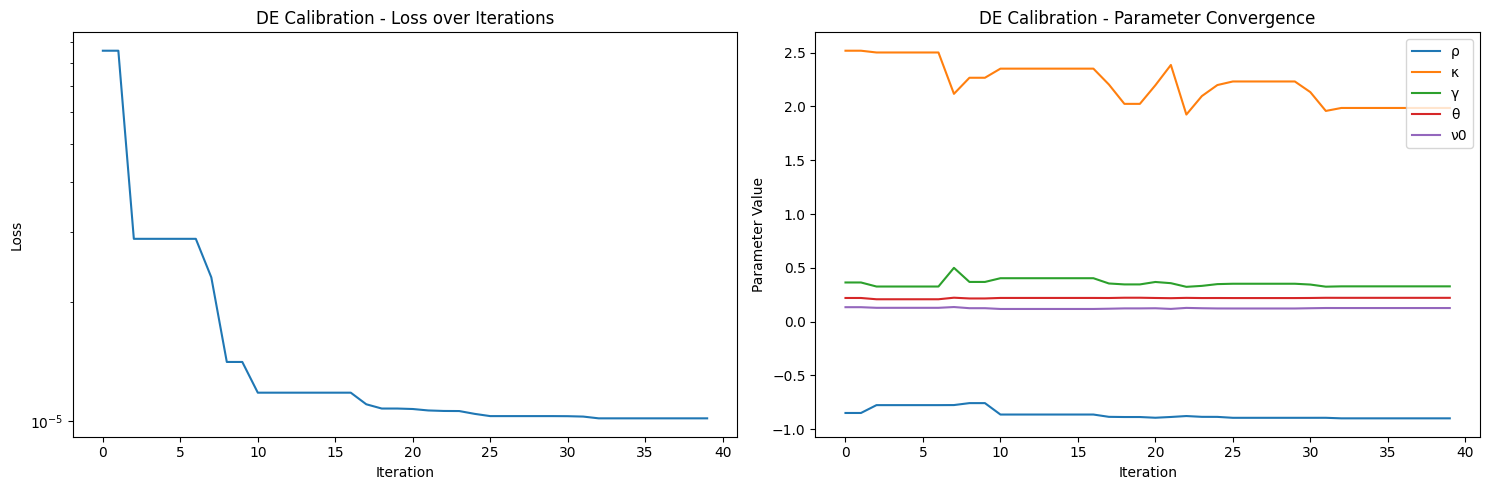


Calibration Execution Time: 216.9167 seconds

🔹 True Heston Parameters 🔹
 tf.Tensor([[-0.8403595   2.7695541   0.40782574  0.21370667  0.11331853]], shape=(1, 5), dtype=float32)

🔹 Calibrated Heston Parameters 🔹
 [[-0.89931322  1.98582712  0.32759315  0.22089691  0.1259858 ]]

🔹 Relative Error (%) 🔹
ρ: 7.02%
κ: 28.30%
γ: 19.67%
θ: 3.36%
ν0: 11.18%


In [12]:
# Step 3: Choose a set of contract parameters and market prices for the calibration
# We calibrate on the available contracts

# Take a simulation of the Heston parameters
random_idx = np.random.randint(0, heston_params.shape[0])
true_heston_params = heston_params[random_idx:random_idx+1]
market_prices = option_prices[random_idx]

# Measure Calibration time
start_calib = time.time()

# Step 4: Backward pass (calibration) using Differential Evolution
print("\n=== Backward Pass: Model Calibration with Differential Evolution ===")

# Configurazione dei parametri per la DE
de_config = {
    'lambda_reg': 1e-7,
    'mutation': 0.65,         # più esplorazione globale
    'recombination': 0.8,    # default bilanciato
    'popsize': 15,      # Dimensione popolazione (moltiplicata per il numero di parametri)
    'maxiter': 40,     # Numero massimo di generazioni
    'tol': 5e-4         # Tolleranza di convergenza
}

# Esecuzione della calibrazione con più semi casuali
best_params, all_results, all_histories = run_multiple_calibrations(
    forward_model,
    expanded_contract_params,
    market_prices,
    n_seeds=1,  # Come nel paper
    **de_config
)

end_calib = time.time()
calib_time = end_calib - start_calib

# Visualizzare i risultati
# Consideriamo il miglior run
best_run_idx = np.argmin([result.fun for result in all_results])
best_history = all_histories[best_run_idx]

# Estrai i dati dalla storia
iterations = [entry['iter'] for entry in best_history]
losses = [entry['loss'] for entry in best_history]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(iterations, losses)
plt.title('DE Calibration - Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')  # Logarithmic scale often helps visualize convergence better

plt.subplot(1, 2, 2)
# Plot parameter convergence
param_names = ['ρ', 'κ', 'γ', 'θ', 'ν0']
params_history = np.array([entry['params'] for entry in best_history])
for i, name in enumerate(param_names):
    plt.plot(iterations, params_history[:, i], label=name)
plt.title('DE Calibration - Parameter Convergence')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nCalibration Execution Time: {calib_time:.4f} seconds\n")
print("🔹 True Heston Parameters 🔹\n", true_heston_params)
print("\n🔹 Calibrated Heston Parameters 🔹\n", best_params)

# Calcola l'errore relativo percentuale
rel_error = np.abs((best_params - true_heston_params.numpy()) / true_heston_params.numpy()) * 100
print("\n🔹 Relative Error (%) 🔹")
for i, name in enumerate(param_names):
    print(f"{name}: {rel_error[0, i]:.2f}%")

# Plot errors of the calibrated model on the market grid

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


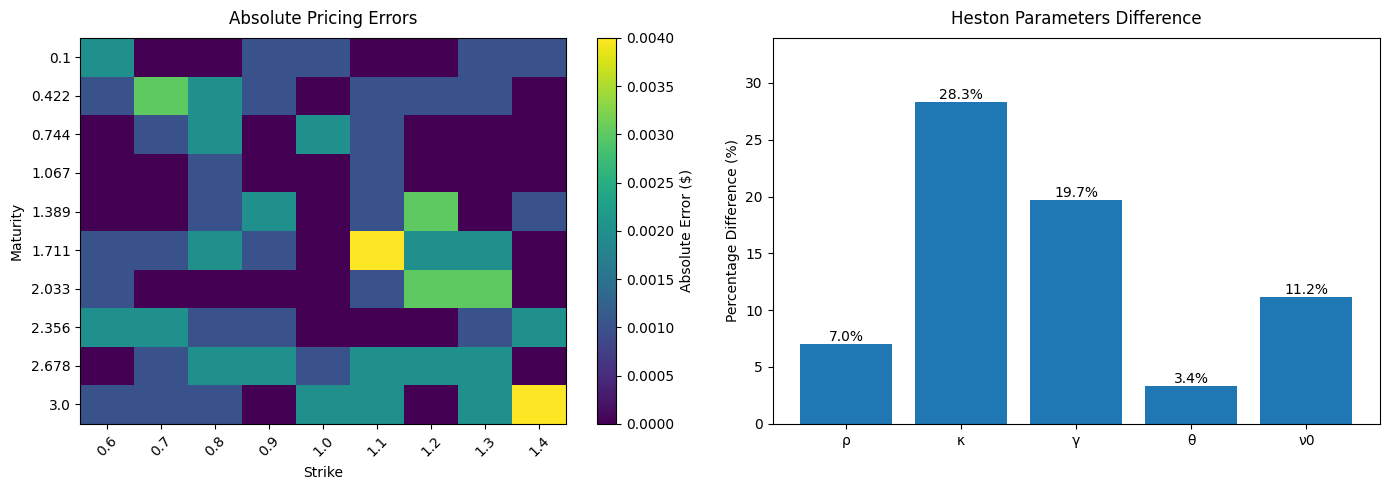

In [13]:
def plot_calibration_errors(true_params, calibrated_params, market_prices, predicted_prices, 
                           strikes, maturities, S0=1.0):
    """
    Visualize calibration results with:
    - Absolute pricing errors for strike/maturity grid (truncated to 3 decimals)
    - Percentage errors for Heston parameters
    
    Parameters:
    - true_params: Ground truth Heston parameters (shape: (5,))
    - calibrated_params: Calibrated Heston parameters (shape: (5,))
    - market_prices: Observed market prices (shape: (n_contracts,))
    - predicted_prices: Model predicted prices (shape: (n_contracts,))
    - strikes: Array of strike prices
    - maturities: Array of maturities (will be truncated to 3 decimals)
    - S0: Spot price (default 1.0)
    """
    # Ensure parameters are 1D arrays
    true_params = np.array(true_params).flatten()
    calibrated_params = np.array(calibrated_params).flatten()
    
    # Truncate maturities to 3 decimal places
    maturities = np.round(maturities, 3)
    
    # Reshape data for visualization
    strikes_dim = len(strikes)
    maturities_dim = len(maturities)
    abs_errors = np.round(np.abs(market_prices - predicted_prices), 3)  # Truncate to 3 decimals
    error_grid = abs_errors.reshape(maturities_dim, strikes_dim)
    
    # Create figure with 2 subplots
    plt.figure(figsize=(14, 5))
    
    # 1. Heatmap of absolute pricing errors
    plt.subplot(1, 2, 1)
    im = plt.imshow(error_grid, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Absolute Error ($)')
    plt.title("Absolute Pricing Errors", fontsize=12, pad=10)
    
    # Set axis labels with truncated values
    ax = plt.gca()
    ax.set_xticks(np.arange(strikes_dim))
    ax.set_xticklabels(np.round(strikes, 3), rotation=45)  # Truncate to 3 decimals
    ax.set_yticks(np.arange(maturities_dim))
    ax.set_yticklabels(maturities)
    ax.set_xlabel("Strike", fontsize=10, labelpad=5)
    ax.set_ylabel("Maturity", fontsize=10, labelpad=5)
    
    # 2. Percentage errors for Heston parameters
    plt.subplot(1, 2, 2)
    with np.errstate(divide='ignore', invalid='ignore'):
        param_diff = 100 * np.abs((true_params - calibrated_params) / true_params)
        param_diff = np.nan_to_num(param_diff, nan=0.0, posinf=0.0, neginf=0.0)
    
    param_names = ['ρ', 'κ', 'γ', 'θ', 'ν0']
    bars = plt.bar(param_names, param_diff)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom')
    
    plt.ylabel('Percentage Difference (%)')
    plt.title("Heston Parameters Difference", fontsize=12, pad=10)
    plt.ylim(0, min(100, max(param_diff)*1.2))
    
    plt.tight_layout()
    plt.show()

# Corrected example usage:
# Ensure calibrated_params is 1D array
# calibrated_params = np.array(calibrated_params).flatten()
best_params = np.array(best_params).flatten()

# Generate predicted prices
heston_params_repeated = np.tile(best_params, (len(expanded_contract_params), 1))
combined_input = np.hstack([heston_params_repeated, expanded_contract_params])
predicted_prices = forward_model.predict(combined_input).flatten()

plot_calibration_errors(
    true_heston_params.numpy().flatten(),  # Ensure 1D array
    best_params,
    market_prices.numpy(),
    predicted_prices,
    strikes=np.round(np.arange(0.6, 1.5, 0.1), 3),  # Truncate to 3 decimals
    maturities=np.round(np.linspace(0.1, 3.0, 10), 3)  # Truncate to 3 decimals
)

# Interpretability analysis
In this section we inspect the importance of each heston parameter on the forward map, i.e how much each Heston parameter contributes to the determination of option prices. Feature importance methods implemented:
- permutation method: for each feature permutate its values and compute the new prediction, check the difference with non permutated prediction
- integrated gradients: create a grid of points to compute the gradients of the output with respect to the inputs
- SHAP values approximation: for every feature, compute the prediction with baseline (average of all features) vs baseline+one real feature and compte the marginal contributions 

In [31]:
from sklearn.base import BaseEstimator
import seaborn as sns
import pandas as pd
import random

# Features names
feature_names = [
    'ρ', 'κ', 'γ', 'θ', 'ν0',  # Heston parameters
    'K', 'T', 'S0', 'r'        # Contracts parameters
]

# 1. PERMUTATION IMPORTANCE CUSTOM
def custom_permutation_importance(model, X, y, feature_names, n_repeats=10):
    """
    Custom implementation of permutation importance.
    Doesn't require the model to be a sklearn estimator.
    """
    print("Calculating custom permutation importance...")
    
    # Function to calculate prediction error
    def calculate_error(X, y):
        preds = model.predict(X, verbose=0)
        # Mean Squared Error
        return np.mean((preds.flatten() - y) ** 2)
    
    # Calculate baseline error
    baseline_error = calculate_error(X, y)
    n_features = X.shape[1]
    
    # Array to store importances
    importances = np.zeros((n_repeats, n_features))
    
    # For each repetition
    for r in range(n_repeats):
        # For each feature
        for i in range(n_features):
            # Create a copy of X
            X_permuted = X.copy()
            
            # Permute values of i-th feature
            X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
            
            # Calculate error with permuted feature
            permuted_error = calculate_error(X_permuted, y)
            
            # Importance is the error increase
            importances[r, i] = permuted_error - baseline_error
    
    # Calculate mean and std of importances
    importance_mean = np.mean(importances, axis=0)
    importance_std = np.std(importances, axis=0)
    
    # Create DataFrame for results
    indices = np.argsort(importance_mean)[::-1]
    
    # Create dataframe for easier visualization
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importance_mean[indices],
        'Std': importance_std[indices],
        'Type': ['Heston' if i < 5 else 'Contract' for i in indices]
    })
    
    return importance_df

# 2. INTEGRATED GRADIENTS
def integrated_gradients(model, X_sample, feature_names, num_steps=50):
    """
    Calculate Integrated Gradients for a TensorFlow model
    """
    print("Calculating integrated gradients...")
    
    # Function to calculate gradients with respect to inputs
    def get_gradients(inputs, target_outputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predictions = model(inputs)
            loss = predictions  # In this case, we're just looking at the derivative of output with respect to input
        return tape.gradient(loss, inputs)
    
    # Select a limited number of samples to speed up analysis
    num_samples = min(100, len(X_sample))
    X_subset = X_sample[:num_samples]
    
    # Create a baseline (typically all zeros)
    baseline = np.zeros_like(X_subset[0])
    
    # Array to store integrated gradients
    integrated_grads = np.zeros((num_samples, len(feature_names)))
    
    for i in range(num_samples):
        x_sample = X_subset[i]
        
        # Create sequence of points between baseline and input
        alphas = np.linspace(0, 1, num_steps)
        interpolated_inputs = np.array([baseline + alpha * (x_sample - baseline) for alpha in alphas])
        
        # Convert to TensorFlow tensor
        interpolated_tensor = tf.convert_to_tensor(interpolated_inputs, dtype=tf.float32)
        
        # Calculate gradients for each interpolated point
        target = model.predict(np.array([x_sample]), verbose=0)
        gradients = get_gradients(interpolated_tensor, target)
        
        # Average gradients
        avg_gradients = tf.reduce_mean(gradients, axis=0).numpy()
        
        # Multiply by difference between input and baseline
        integrated_grads[i] = avg_gradients * (x_sample - baseline)
    
    # Average integrated gradients across all samples
    feature_importance = np.abs(integrated_grads).mean(axis=0)
    
    # Create dataframe for visualization
    indices = np.argsort(feature_importance)[::-1]
    ig_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': feature_importance[indices],
        'Type': ['Heston' if i < 5 else 'Contract' for i in indices]
    })
    
    return ig_df

# 3. SHAP-LIKE APPROXIMATION
def shapley_approximation(model, X_sample, feature_names, num_samples=100):
    """
    SHAP values approximation for feature importance
    """
    print("Calculating Shapley value approximation...")
    
    num_features = len(feature_names)
    num_samples = min(num_samples, len(X_sample))
    
    # Create baseline (mean of all samples)
    baseline = np.mean(X_sample, axis=0)
    
    # Array to store Shapley values
    shapley_values = np.zeros((num_samples, num_features))
    
    # For each sample
    for i in range(num_samples):
        x = X_sample[i]
        
        # Calculate prediction with all features
        full_prediction = model.predict(np.array([x]), verbose=0)[0][0]
        
        # Calculate prediction with no features (baseline)
        baseline_prediction = model.predict(np.array([baseline]), verbose=0)[0][0]
        
        # For each feature
        for j in range(num_features):
            # Create new input with only j-th feature from real sample
            x_only_j = baseline.copy()
            x_only_j[j] = x[j]
            pred_only_j = model.predict(np.array([x_only_j]), verbose=0)[0][0]
            
            # Calculate marginal contribution of feature j
            shapley_values[i, j] = pred_only_j - baseline_prediction
    
    # Average Shapley values across all samples
    shapley_mean = np.abs(shapley_values).mean(axis=0)
    
    # Create dataframe for visualization
    indices = np.argsort(shapley_mean)[::-1]
    shapley_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': shapley_mean[indices],
        'Type': ['Heston' if i < 5 else 'Contract' for i in indices]
    })
    
    return shapley_df

# Function to visualize results
def plot_all_feature_importance(perm_df, ig_df, shapley_df, feature_names):
    """
    Visualize feature importance analysis results
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))
    
    # 1. Custom Permutation Importance
    sns.barplot(
        data=perm_df, 
        x='Importance', 
        y='Feature',
        hue='Type',
        palette={'Heston': 'darkblue', 'Contract': 'lightblue'},
        ax=axes[0]
    )
    axes[0].set_title('Custom Permutation Importance', fontsize=14)
    axes[0].set_xlabel('Error increase when feature is permuted')
    axes[0].set_ylabel('Feature')
    
    # 2. Integrated Gradients
    sns.barplot(
        data=ig_df, 
        x='Importance', 
        y='Feature',
        hue='Type',
        palette={'Heston': 'darkgreen', 'Contract': 'lightgreen'},
        ax=axes[1]
    )
    axes[1].set_title('Integrated Gradients', fontsize=14)
    axes[1].set_xlabel('Integrated gradient magnitude')
    axes[1].set_ylabel('Feature')
    
    # 3. Shapley Approximation
    sns.barplot(
        data=shapley_df, 
        x='Importance', 
        y='Feature',
        hue='Type',
        palette={'Heston': 'darkred', 'Contract': 'salmon'},
        ax=axes[2]
    )
    axes[2].set_title('Shapley Value Approximation', fontsize=14)
    axes[2].set_xlabel('Average marginal contribution')
    axes[2].set_ylabel('Feature')
    
    plt.tight_layout()
    plt.show()

# For Heston parameters only
def plot_heston_params_importance(perm_df, ig_df, shapley_df):
    """
    Visualize results only for Heston parameters
    """
    # Filter only Heston parameters
    perm_heston = perm_df[perm_df['Type'] == 'Heston']
    ig_heston = ig_df[ig_df['Type'] == 'Heston']
    shapley_heston = shapley_df[shapley_df['Type'] == 'Heston']
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    # 1. Custom Permutation Importance for Heston parameters
    sns.barplot(
        data=perm_heston, 
        x='Importance', 
        y='Feature',
        color='darkblue',
        ax=axes[0]
    )
    axes[0].set_title('Custom Permutation Importance (Heston Parameters)', fontsize=14)
    axes[0].set_xlabel('Error increase')
    axes[0].set_ylabel('Heston Parameter')
    
    # 2. Integrated Gradients for Heston parameters
    sns.barplot(
        data=ig_heston, 
        x='Importance', 
        y='Feature',
        color='darkgreen',
        ax=axes[1]
    )
    axes[1].set_title('Integrated Gradients (Heston Parameters)', fontsize=14)
    axes[1].set_xlabel('Gradient magnitude')
    axes[1].set_ylabel('Heston Parameter')
    
    # 3. Shapley Approximation for Heston parameters
    sns.barplot(
        data=shapley_heston, 
        x='Importance', 
        y='Feature',
        color='darkred',
        ax=axes[2]
    )
    axes[2].set_title('Shapley Value Approximation (Heston Parameters)', fontsize=14)
    axes[2].set_xlabel('Marginal contribution')
    axes[2].set_ylabel('Heston Parameter')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_feature_importance_alternative(model, X_test, y_test):
    """
    Run all alternative feature importance analyses
    """
    # 1. Custom Permutation Importance
    perm_df = custom_permutation_importance(model, X_test, y_test, feature_names)
    
    # 2. Integrated Gradients
    ig_df = integrated_gradients(model, X_test, feature_names)
    
    # 3. Shapley Approximation
    shapley_df = shapley_approximation(model, X_test, feature_names)
    
    # Visualize all results
    plot_all_feature_importance(perm_df, ig_df, shapley_df, feature_names)
    
    # Visualize only Heston parameters
    plot_heston_params_importance(perm_df, ig_df, shapley_df)
    
    return perm_df, ig_df, shapley_df

# Bonus function: feature-prediction correlation matrix
def feature_prediction_correlation(model, X, feature_names):
    """
    Calculate correlation between each feature and model predictions
    """
    print("Calculating feature-prediction correlations...")
    
    # Get predictions
    predictions = model.predict(X, verbose=0).flatten()
    
    # Calculate Pearson correlations
    correlations = []
    for i in range(X.shape[1]):
        corr = np.corrcoef(X[:, i], predictions)[0, 1]
        correlations.append((feature_names[i], abs(corr), corr >= 0))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    # Visualize correlations
    plt.figure(figsize=(10, 6))
    features = [c[0] for c in correlations]
    values = [c[1] * (1 if c[2] else -1) for c in correlations]
    colors = ['green' if v >= 0 else 'red' for v in values]
    
    plt.bar(features, values, color=colors)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.title('Correlation Between Features and Model Predictions')
    plt.xlabel('Feature')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Return results dataframe
    corr_df = pd.DataFrame({
        'Feature': [c[0] for c in correlations],
        'Abs_Correlation': [c[1] for c in correlations],
        'Direction': ['Positive' if c[2] else 'Negative' for c in correlations],
        'Type': ['Heston' if feature_names.index(c[0]) < 5 else 'Contract' for c in correlations]
    })
    
    return corr_df

# Function for quick model sensitivity visualization
def sensitivity_analysis(model, X_test, feature_names, num_samples=3):
    """
    Model sensitivity analysis by varying one feature at a time
    """
    print("Performing sensitivity analysis...")
    
    # Select random samples
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)
    samples = X_test[random_indices]
    
    # For each feature
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature_idx in enumerate(range(min(9, len(feature_names)))):
        feature_name = feature_names[feature_idx]
        
        # Create range of values for the feature
        orig_value = samples[0, feature_idx]
        min_val = np.min(X_test[:, feature_idx])
        max_val = np.max(X_test[:, feature_idx])
        
        # Create array of values between min and max
        feature_values = np.linspace(min_val, max_val, 50)
        
        # For each value, create new input and make prediction
        predictions = []
        for val in feature_values:
            modified_sample = samples[0].copy()
            modified_sample[feature_idx] = val
            pred = model.predict(np.array([modified_sample]), verbose=0)[0][0]
            predictions.append(pred)
        
        # Plot sensitivity
        ax = axes[i]
        ax.plot(feature_values, predictions)
        ax.scatter([orig_value], [model.predict(np.array([samples[0]]), verbose=0)[0][0]], 
                  color='red', s=50, label='Original value')
        ax.set_title(f'Sensitivity to {feature_name}')
        ax.set_xlabel(f'{feature_name} value')
        ax.set_ylabel('Model prediction')
        ax.axvline(x=orig_value, color='r', linestyle='--', alpha=0.5)
        
        if i < 5:
            ax.set_facecolor('#f0f8ff')  # Light color for Heston parameters
        
    plt.tight_layout()
    plt.show()

# Complete function to run all analyses
def comprehensive_feature_analysis(model, X_test, y_test):
    """
    Run comprehensive feature analysis
    """
    print("\n==== COMPREHENSIVE FEATURE ANALYSIS ====\n")
    
    # 1. Feature importance methods
    perm_df, ig_df, shapley_df = analyze_feature_importance_alternative(model, X_test, y_test)
    
    # 2. Feature-prediction correlation
    corr_df = feature_prediction_correlation(model, X_test, feature_names)
    
    # 3. Sensitivity analysis
    sensitivity_analysis(model, X_test, feature_names)
    
    # Results summary
    print("\n==== RESULTS SUMMARY ====\n")
    
    # Aggregate importance ranks from different metrics
    top_features = {}
    
    # From permutation importance results
    for i, feature in enumerate(perm_df['Feature']):
        if feature not in top_features:
            top_features[feature] = []
        top_features[feature].append(i)
    
    # From integrated gradients results
    for i, feature in enumerate(ig_df['Feature']):
        if feature not in top_features:
            top_features[feature] = []
        top_features[feature].append(i)
    
    # From Shapley values results
    for i, feature in enumerate(shapley_df['Feature']):
        if feature not in top_features:
            top_features[feature] = []
        top_features[feature].append(i)
    
    # Calculate average rank
    avg_ranks = {feature: np.mean(ranks) for feature, ranks in top_features.items()}
    
    # Sort features by average rank
    sorted_features = sorted(avg_ranks.items(), key=lambda x: x[1])
    
    print("Most important features (in order of importance):")
    for i, (feature, avg_rank) in enumerate(sorted_features[:5]):
        print(f"{i+1}. {feature} (average rank: {avg_rank:.2f})")
    
    # Return all results
    return {
        'permutation_importance': perm_df,
        'integrated_gradients': ig_df,
        'shapley_values': shapley_df,
        'correlations': corr_df,
        'average_ranks': sorted_features
    }


==== COMPREHENSIVE FEATURE ANALYSIS ====

Calculating custom permutation importance...
Calculating integrated gradients...
Calculating Shapley value approximation...


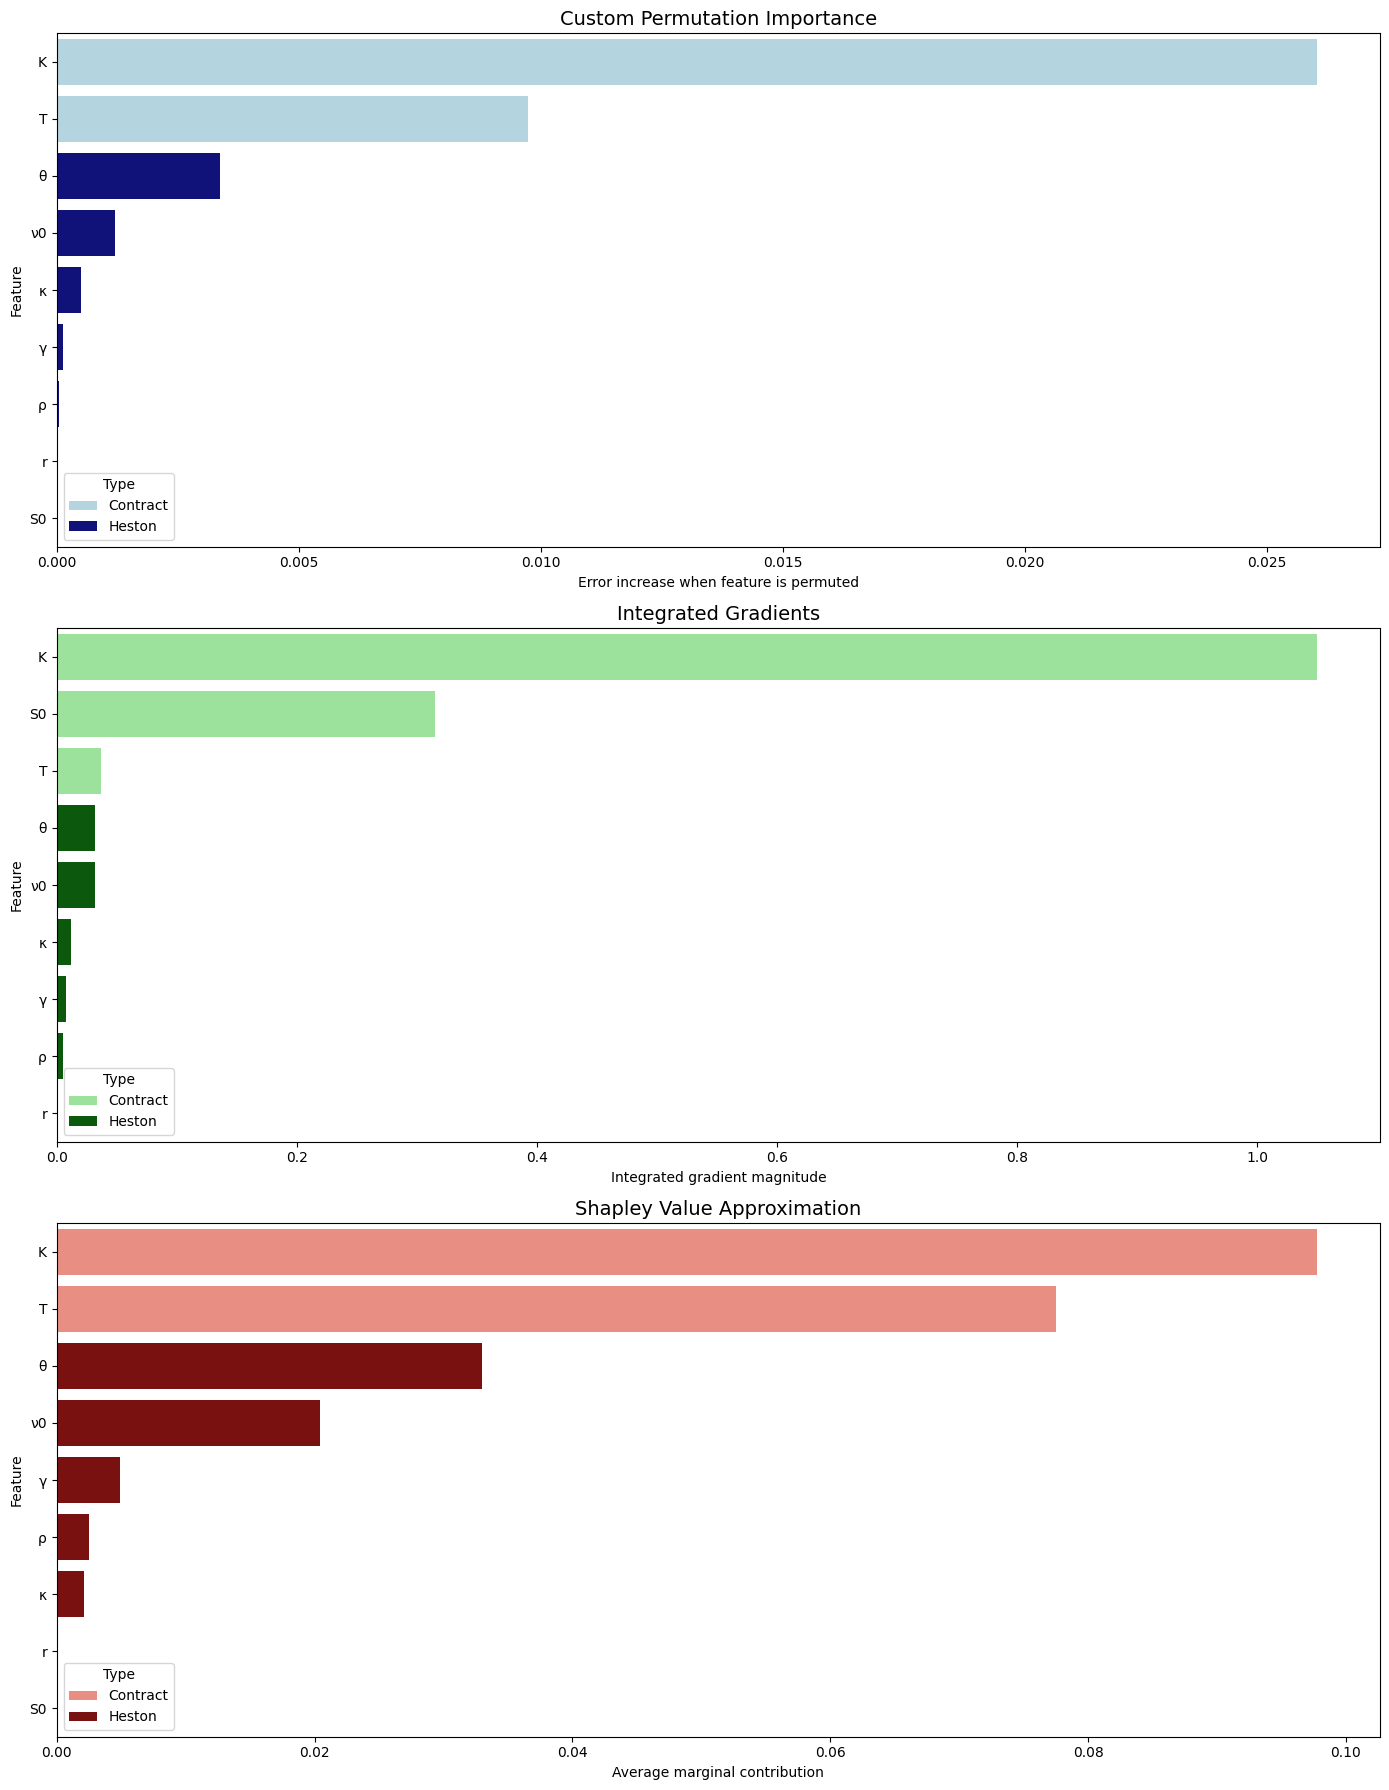

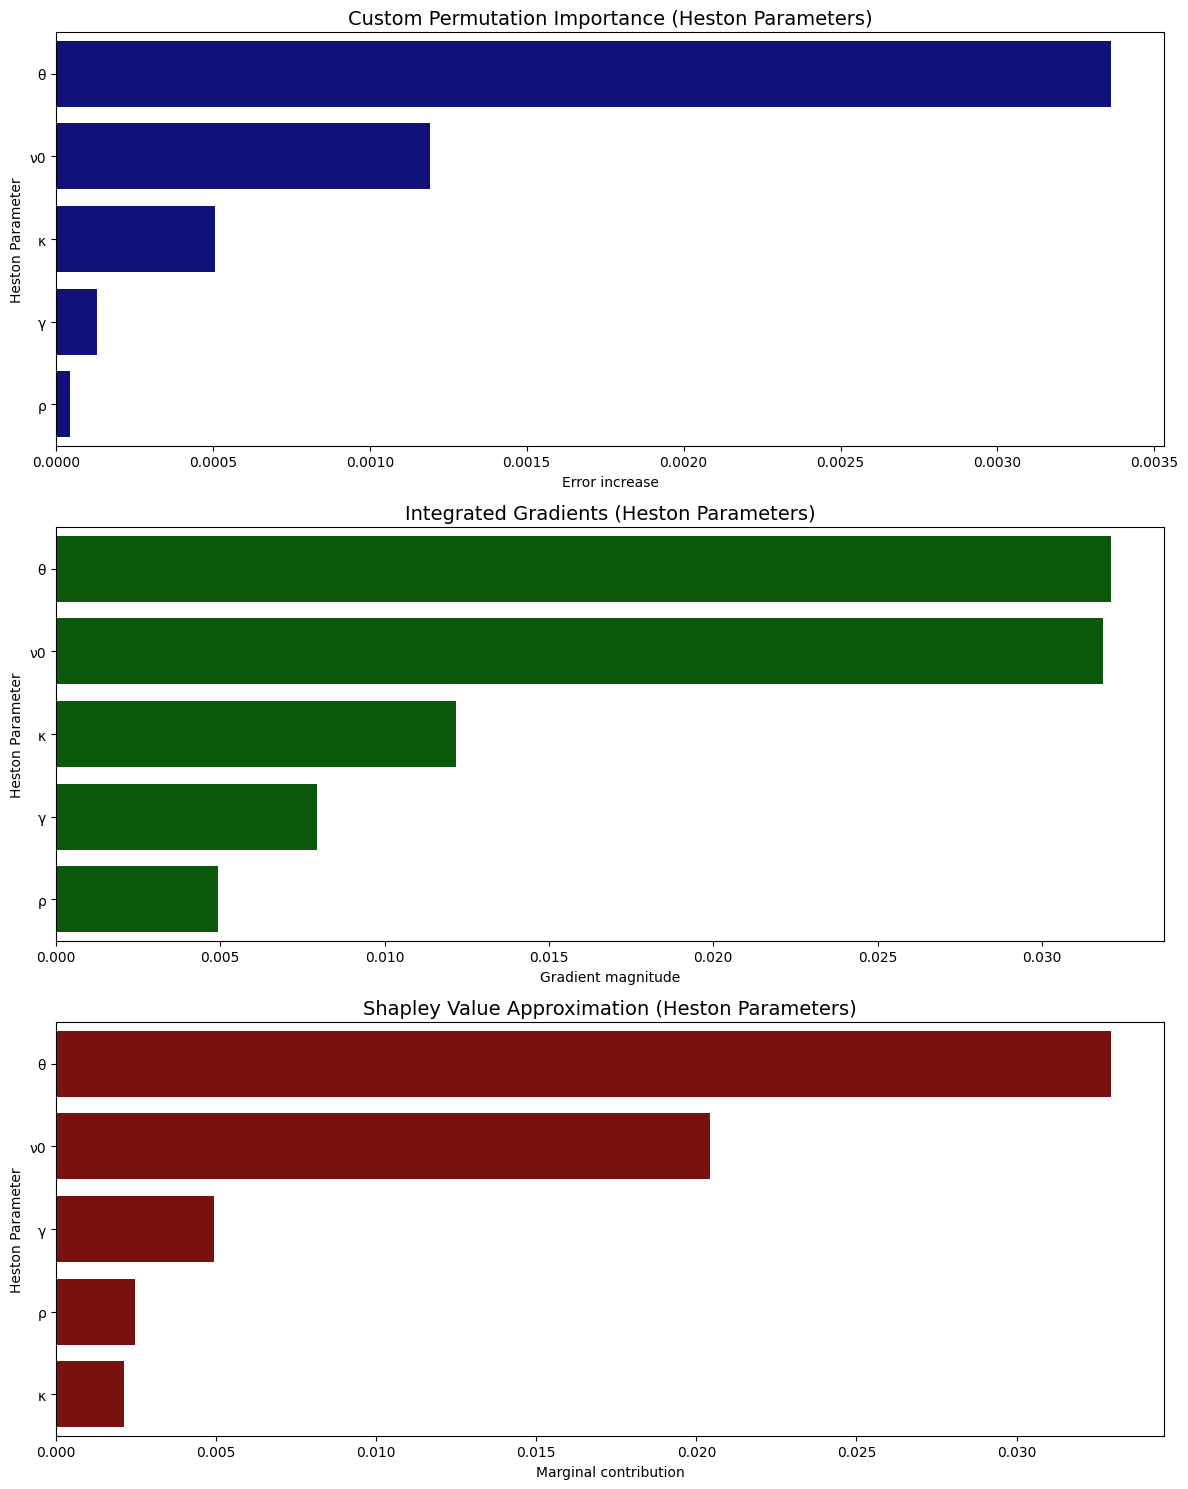

Calculating feature-prediction correlations...


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


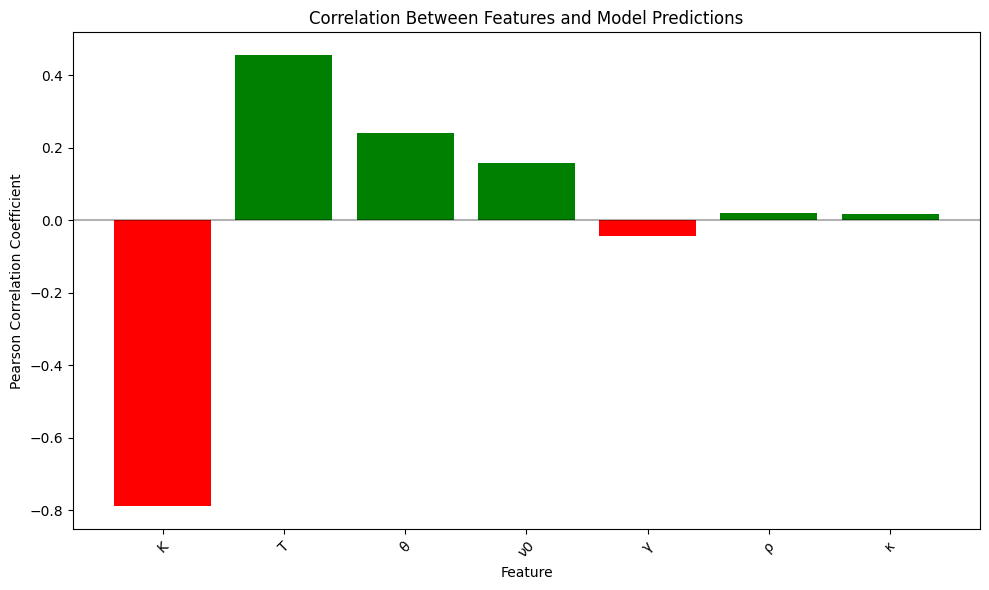

Performing sensitivity analysis...


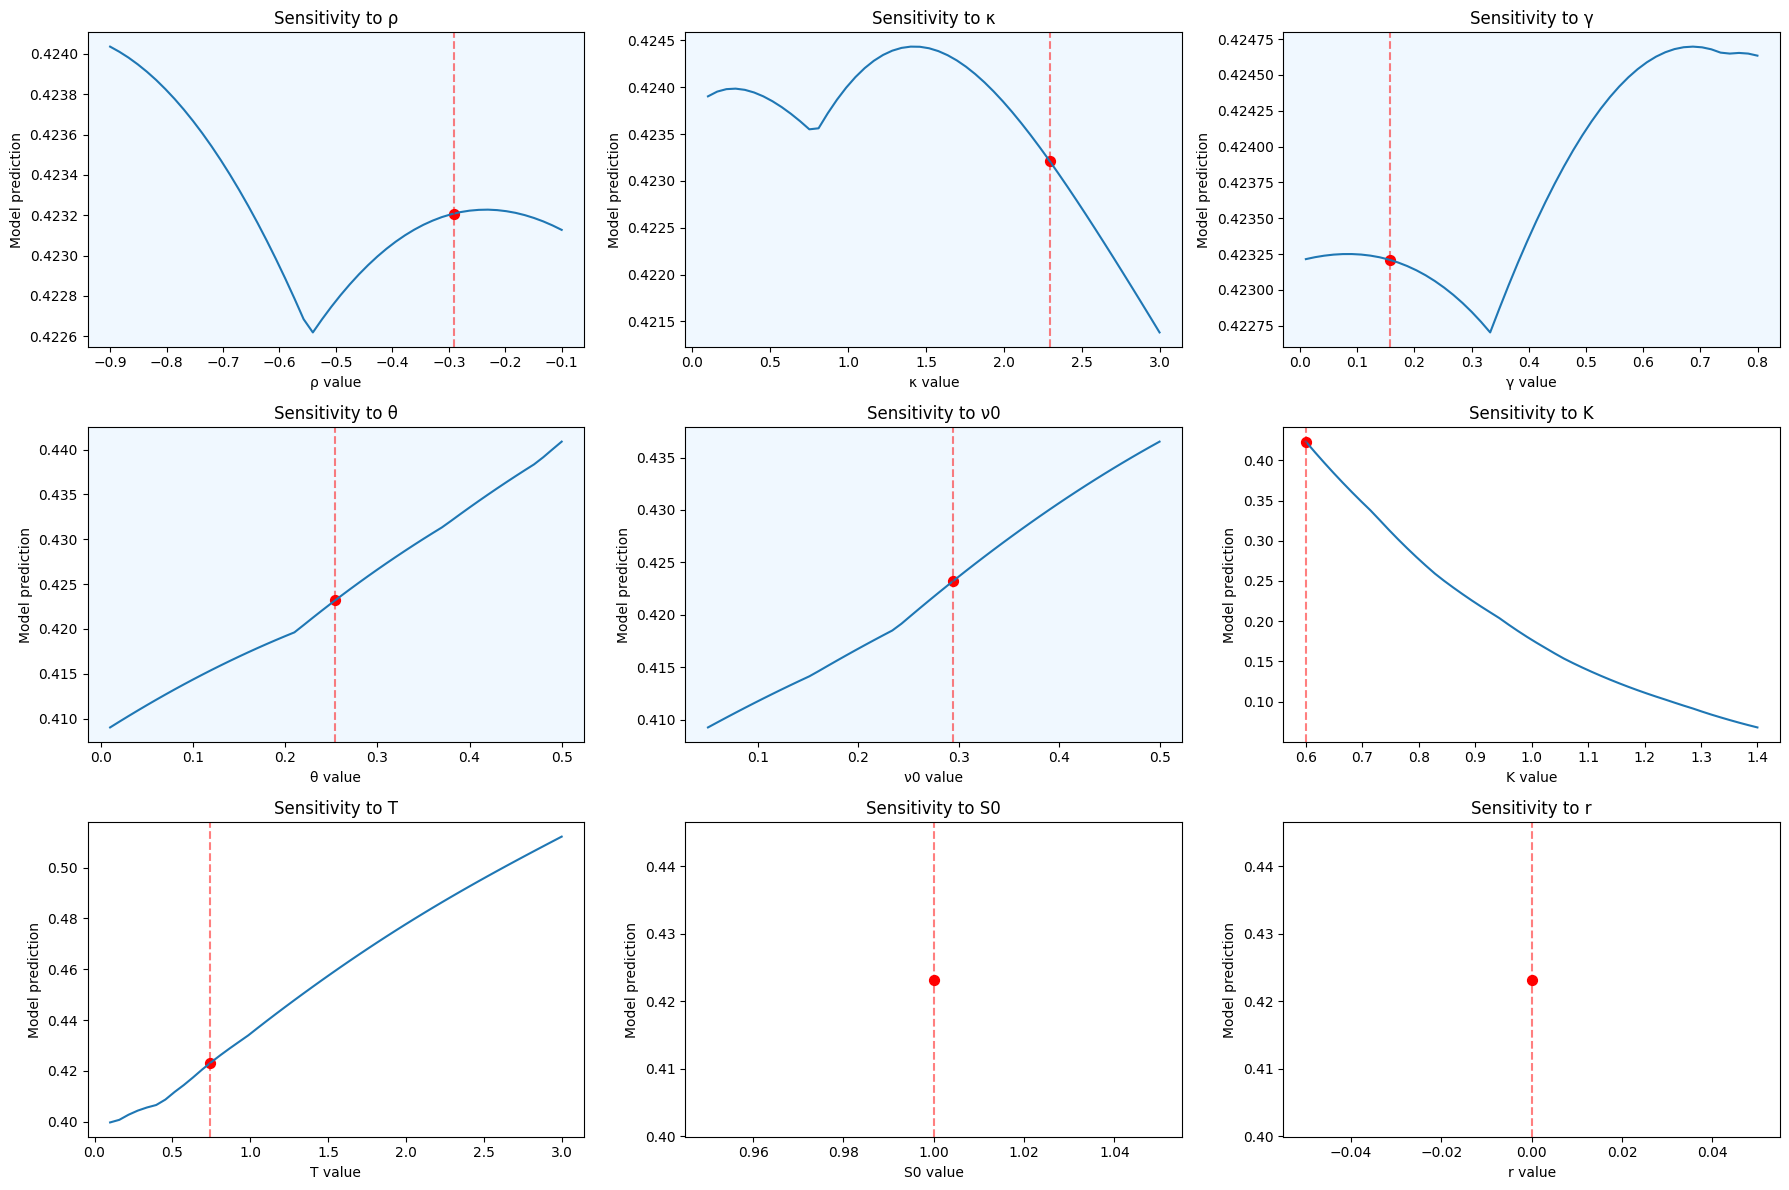


==== RESULTS SUMMARY ====

Most important features (in order of importance):
1. K (average rank: 0.00)
2. T (average rank: 1.33)
3. θ (average rank: 2.33)
4. ν0 (average rank: 3.33)
5. κ (average rank: 5.00)
Calculating custom permutation importance...
Calculating integrated gradients...
Calculating Shapley value approximation...


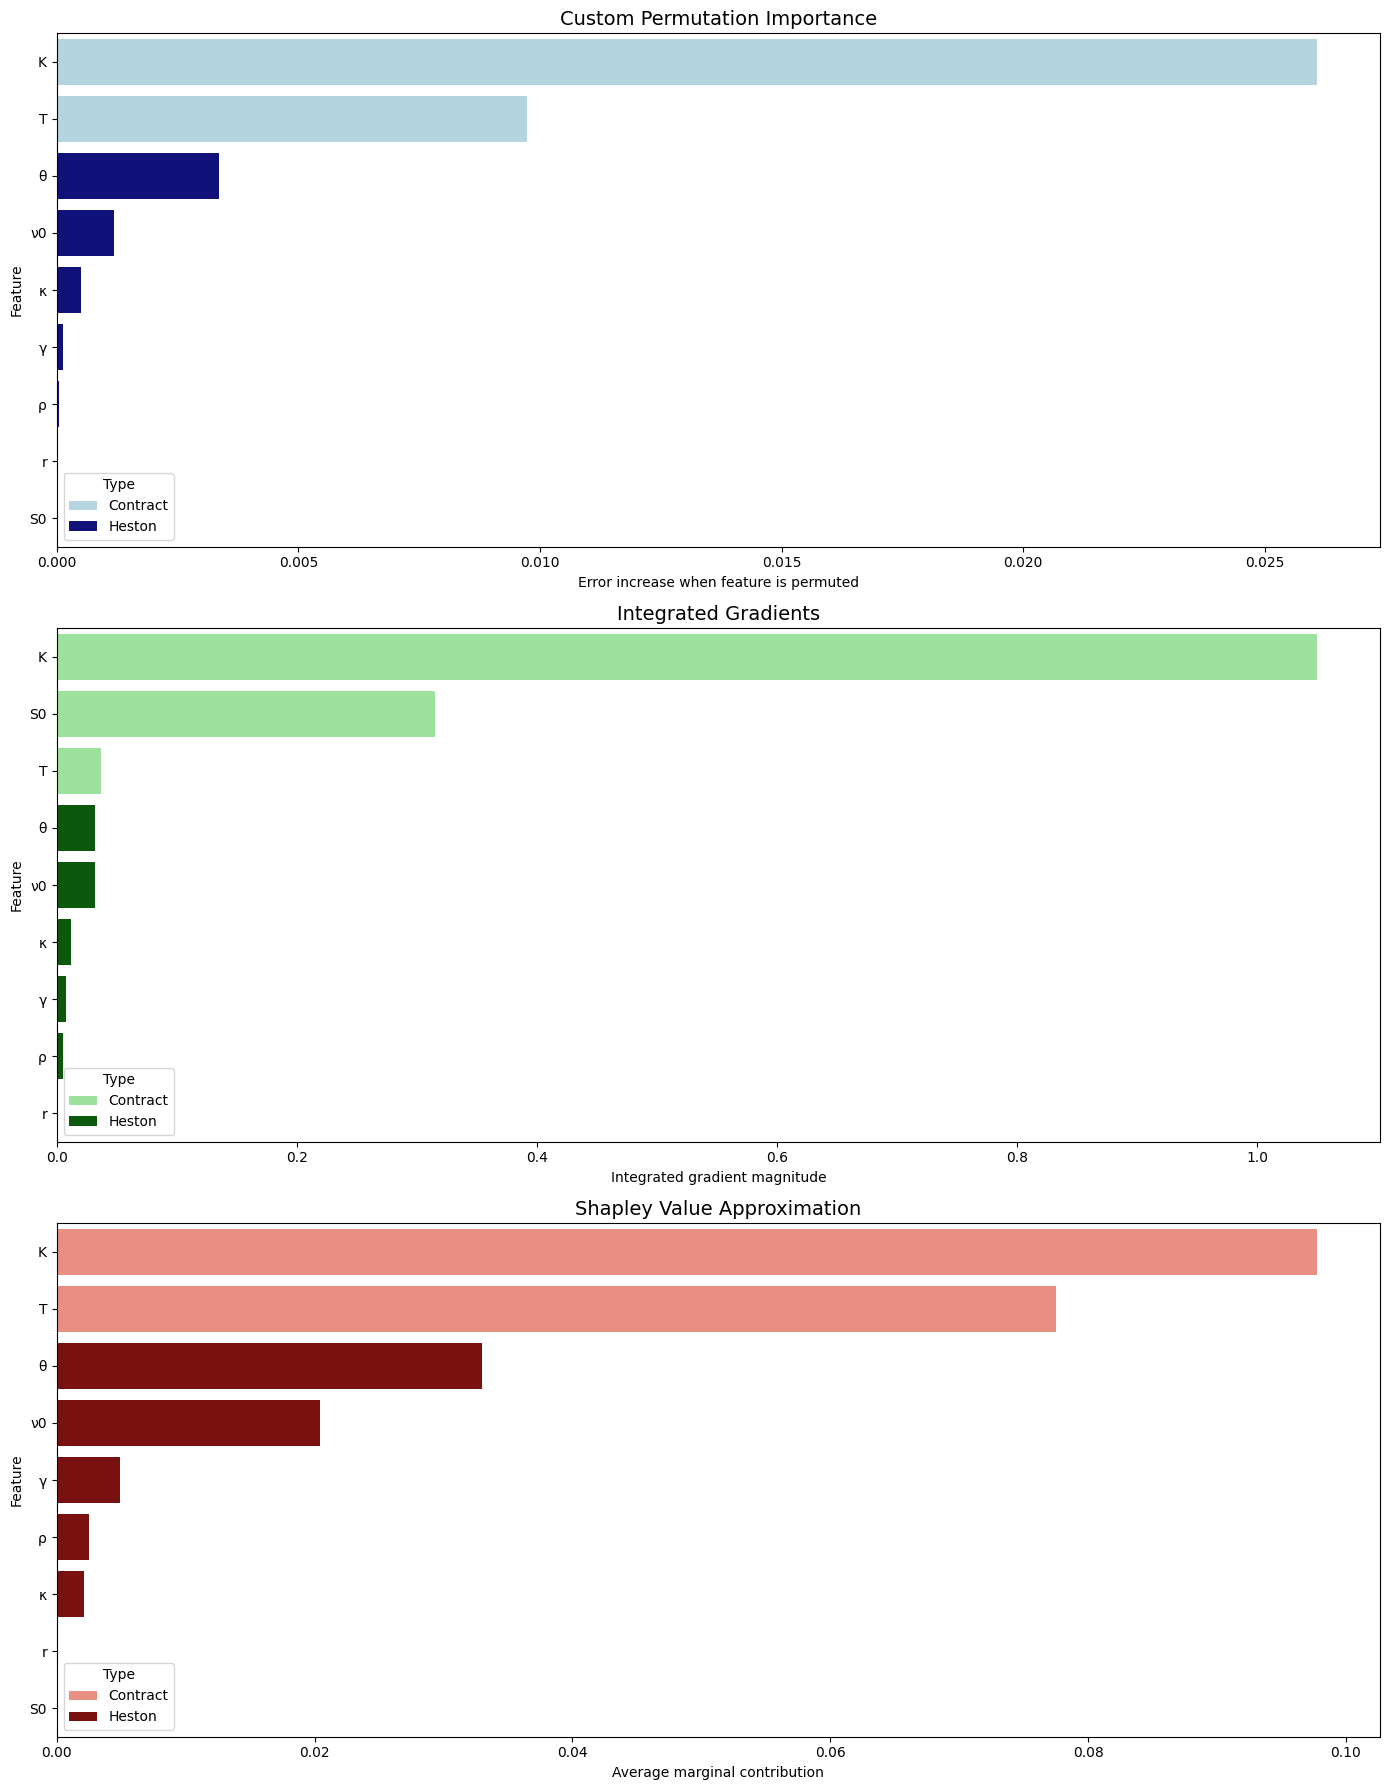

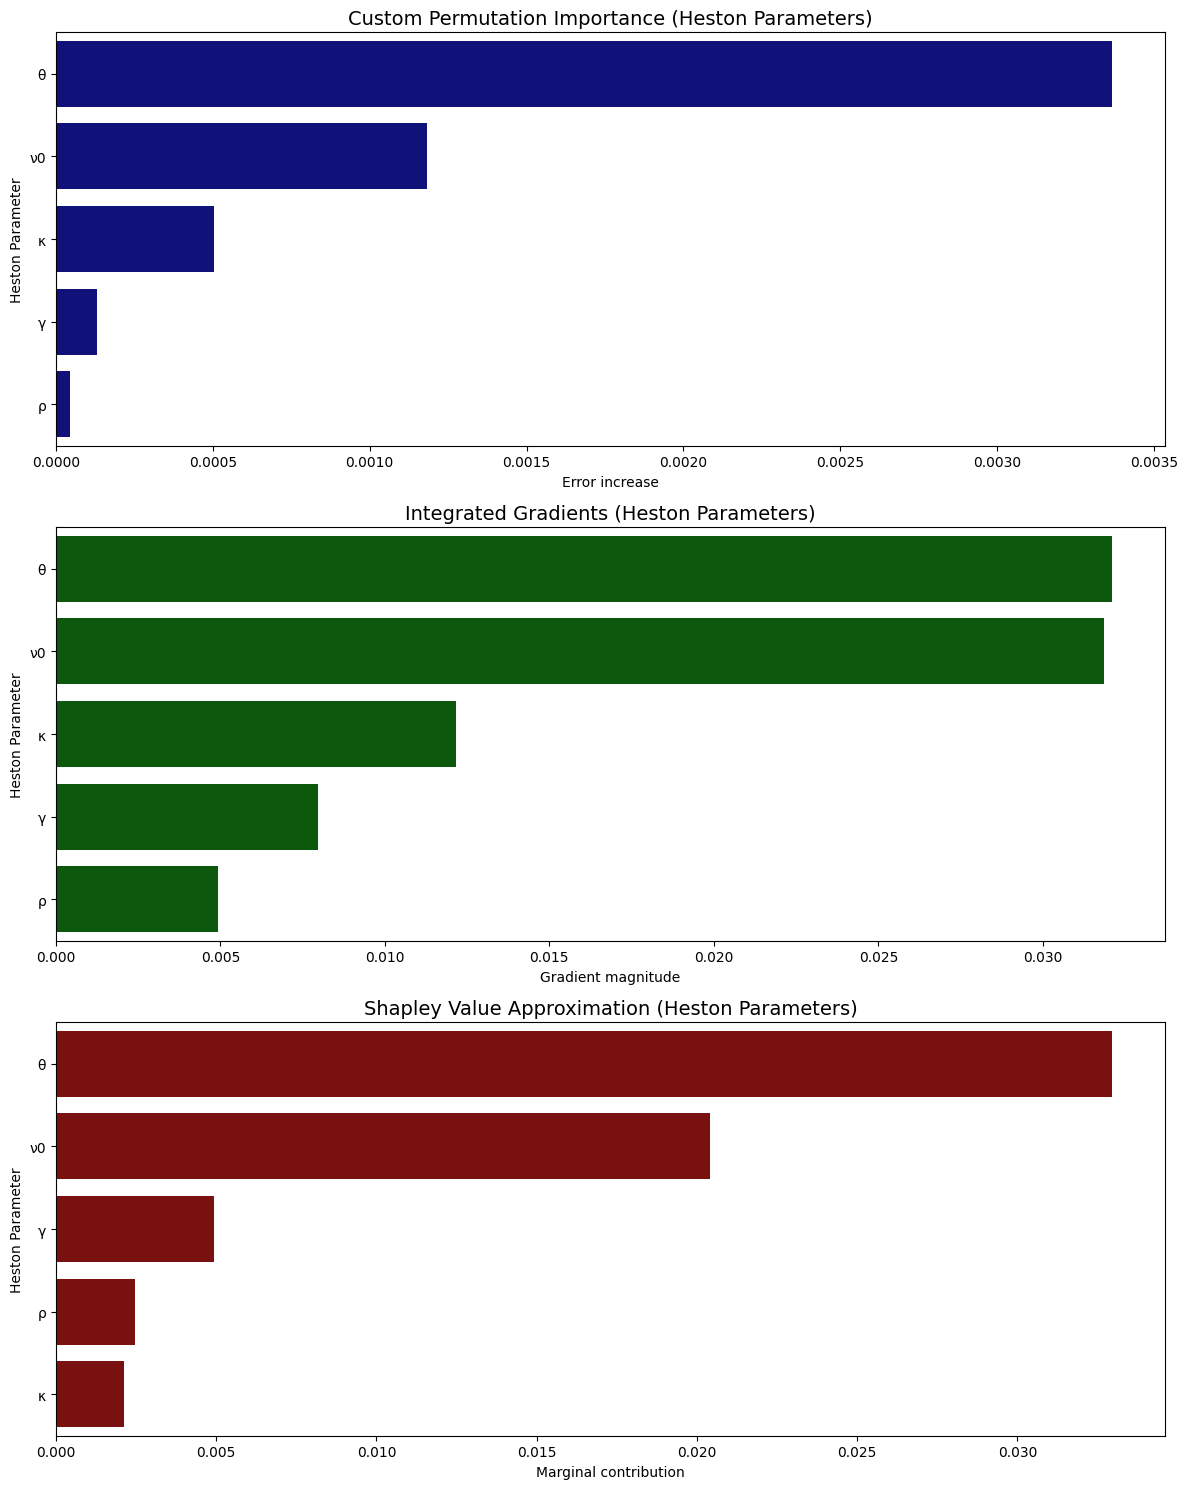

In [32]:
# Complete analysis of all the features
results = comprehensive_feature_analysis(forward_model, X_test, y_test)

# Alternative feature importance analysis
perm_df, ig_df, shapley_df = analyze_feature_importance_alternative(forward_model, X_test, y_test)